# NETW 1013 Clustering Project 

**Objective:** 
The objective of this project is to teach students how to apply clustering to real datasets.

You should be able to answer the following questions and provide reasonable justification for your answers: 
* Which clustering approach have you decided to use on each dataset? 
* Compare between Kmeans, Hierarchal and DBScan.
* Discuss how you tuned your clustering hyperparameters to achieve the best cluster assignment?
* What is the effect of different distance functions on the calculated clusters?
* How did you evaluate the performance of different clustering techniques on different datatsets?
* Visualize your output where applicable.
* What is the effect of scaling on the performance of clustering techniques? 

 
 



Running this project requires the following imports:

##### Imports

In [2]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as prep
from plotnine import *
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans, kmeans_plusplus
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import plotly.express as px


# StandardScaler is a function to normalize the data
# You may also check MinMaxScaler and MaxAbsScaler
# from sklearn.preprocessing import StandardScaler


%matplotlib inline
# Please refer to the sklearn documentation to learn more about the different parameters for each clustering technique.

##### Functions

In [5]:
def plot_dbscan(X, eps=0.3, min_samples=5):
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples,random_state=42)
    labels = dbscan.fit_predict(X)

    # Get unique labels (clusters + noise)
    unique_labels = set(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))  # Assign colors

    plt.figure(figsize=(8, 6))

    for label, color in zip(unique_labels, colors):
        if label == -1:
            color = "black"  # Noise points in black

        # Select points in the cluster
        cluster_points = X[labels == label]
        plt.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            c=[color],
            label=f"Cluster {label}" if label != -1 else "Noise",
            s=10,
        )

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("DBSCAN Clustering")
    plt.legend()
    plt.show()

In [7]:
# Function to compute cluster centroids manually
def compute_centroids(X, labels, num_clusters):
    centroids = np.array([X[labels == i].mean(axis=0) for i in range(num_clusters)])
    return centroids


# Updated colors for better visualization
color = "brgcmyk"  # List colors


# Modified function for hierarchical clustering with centroids
def display_cluster(X, labels=[], num_clusters=0, title="", legend=True):
    alpha = 0.7
    s = 40  # Size of points
    plt.figure(figsize=(8, 6))
    if num_clusters == 0:
        plt.scatter(X[:, 0], X[:, 1], c=color[0], alpha=alpha, s=s)
    else:
        # Compute estimated centroids
        centroids = compute_centroids(X, labels, num_clusters)

        for i in range(num_clusters):
            plt.scatter(
                X[labels == i, 0],
                X[labels == i, 1],
                c=color[i % len(color)],
                alpha=alpha,
                s=s,
                label=f"Cluster {i}",
            )
            plt.scatter(
                centroids[i, 0],
                centroids[i, 1],
                c="black",
                marker="X",
                s=150,
                edgecolors="white",
                linewidth=2,
            )
        if legend:
            plt.legend()
    plt.title(f"{title} ({num_clusters} Clusters)")
    plt.show()

In [9]:
def Tune_AgglomerativeClustering(df,n_clusters_range = np.arange(2, 21),
                                 linkage_list = ["average", "single", "complete", "ward"],
                                 affinity_list = ["euclidean", "manhattan", "cosine"]):
    # Create an empty DataFrame to store results
    results_df = pd.DataFrame(
        columns=["model", "n_clusters", "affinity", "linkage", "silhouette_score", "db_score"]
    )
    
    # Variables to track the best models
    best_silhouette = -1  # Higher is better
    best_db_score = float("inf")  # Lower is better
    
    best_silhouette_model = None
    best_db_model = None
    
    # Loop through different cluster numbers, affinity, and linkage types
    for n_clusters in n_clusters_range:
        for affinity in affinity_list:
            for linkage in linkage_list:
                if linkage == "ward" and affinity != "euclidean":
                    continue  # Ward linkage only works with Euclidean distance
                try:
                    # Train the model
                    model = AgglomerativeClustering(
                        n_clusters=n_clusters, metric=affinity, linkage=linkage
                    )
                    model.fit(df)
    
                    # Compute scores
                    silhouette = silhouette_score(df, model.labels_)
                    db_score = davies_bouldin_score(df, model.labels_)
    
                    # Append results to DataFrame
                    new_row = pd.DataFrame(
                        [
                            {
                                "model": model,
                                "n_clusters": n_clusters,
                                "affinity": affinity,
                                "linkage": linkage,
                                "silhouette_score": silhouette,
                                "db_score": db_score,
                            }
                        ]
                    )
                    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
                    # Update best models
                    if silhouette > best_silhouette:
                        best_silhouette = silhouette
                        best_silhouette_model = {
                            "n_clusters": n_clusters,
                            "affinity": affinity,
                            "linkage": linkage,
                            "silhouette_score": silhouette,
                            "db_score": db_score,
                        }
    
                    if db_score < best_db_score:
                        best_db_score = db_score
                        best_db_model = {
                            "n_clusters": n_clusters,
                            "affinity": affinity,
                            "linkage": linkage,
                            "silhouette_score": silhouette,
                            "db_score": db_score,
                        }
    
                except Exception as e:
                    print(
                        f"Skipping: n_clusters={n_clusters}, affinity={affinity}, linkage={linkage} due to error: {e}"
                    )
    
    # Get the index of the best model from the DataFrame based on silhouette score
    best_silhouette_model_index = results_df[
        results_df["silhouette_score"] == best_silhouette_model.get("silhouette_score")
    ].index[0]
    
    # Get the index of the best model from the DataFrame based on Davies-Bouldin score
    best_db_score_model_index = results_df[
        results_df["db_score"] == best_db_model.get("db_score")
    ].index[0]
    
    # Print the best model details including index for Silhouette Score
    print(f"\nBest Agglomerative Clustering Model Based on Silhouette Score (Index {best_silhouette_model_index} in DataFrame):")
    print(f" - n_clusters: {best_silhouette_model['n_clusters']}")
    print(f" - Affinity: {best_silhouette_model['affinity']}")
    print(f" - Linkage: {best_silhouette_model['linkage']}")
    print(f" - Silhouette Score: {best_silhouette_model['silhouette_score']:.4f}")
    print(f" - Davies-Bouldin Score: {best_silhouette_model['db_score']:.4f}")
    
    # Print the best model details including index for Davies-Bouldin Score
    print(f"\nBest Agglomerative Clustering Model Based on Davies-Bouldin Score (Index {best_db_score_model_index} in DataFrame):")
    print(f" - n_clusters: {best_db_model['n_clusters']}")
    print(f" - Affinity: {best_db_model['affinity']}")
    print(f" - Linkage: {best_db_model['linkage']}")
    print(f" - Silhouette Score: {best_db_model['silhouette_score']:.4f}")
    print(f" - Davies-Bouldin Score: {best_db_model['db_score']:.4f}")


    return results_df, best_silhouette_model, best_db_model

## Multi Blob Data Set 
* The dataset generated below is known to be best clustered into 6 clusters.
* Cluster the data set below using the three different clustering techniques discussed in the course.
* Visualize your clustering output in each step of your work.



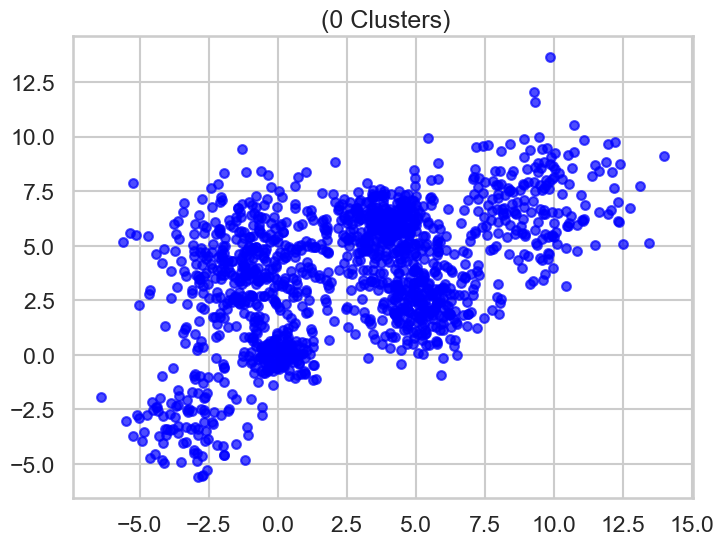

In [69]:
# Data Generation and Visualization
plt.rcParams["figure.figsize"] = [8, 8]
sns.set_style("whitegrid")
sns.set_context("talk")

n_bins = 6
centers = [(-3, -3), (0, 0), (5, 2.5), (-1, 4), (4, 6), (9, 7)]
Multi_blob_Data, y = make_blobs(
    n_samples=[100, 150, 300, 400, 300, 200],
    n_features=2,
    cluster_std=[1.3, 0.6, 1.2, 1.7, 0.9, 1.7],
    centers=centers,
    shuffle=False,
    random_state=42,
)
display_cluster(Multi_blob_Data)

In [70]:
Multi_blob_Data_Scaled = StandardScaler().fit_transform(Multi_blob_Data)
Multi_blob_Data_Scaled

array([[-1.26719967, -2.24928146],
       [-1.2175423 , -1.5406789 ],
       [-1.50759118, -2.29017465],
       ...,
       [ 1.82415545,  3.28071405],
       [ 0.70912955,  2.05274183],
       [ 1.48190485,  1.25100904]])

### Kmeans 
* Use Kmeans with different values of K to cluster the above data. 
* Display the outcome of each value of K. 
* Plot distortion function versus K and choose the approriate value of K. 
* Plot the silhouette_score versus K and use it to choose the best K. 
* Store the silhouette_score for the best K for later comparison with other clustering techniques. 
* Comment on the effect of centroid initialization on cluster assignment. 
* Hint: Lookup k-means++ .

#### Different values of K

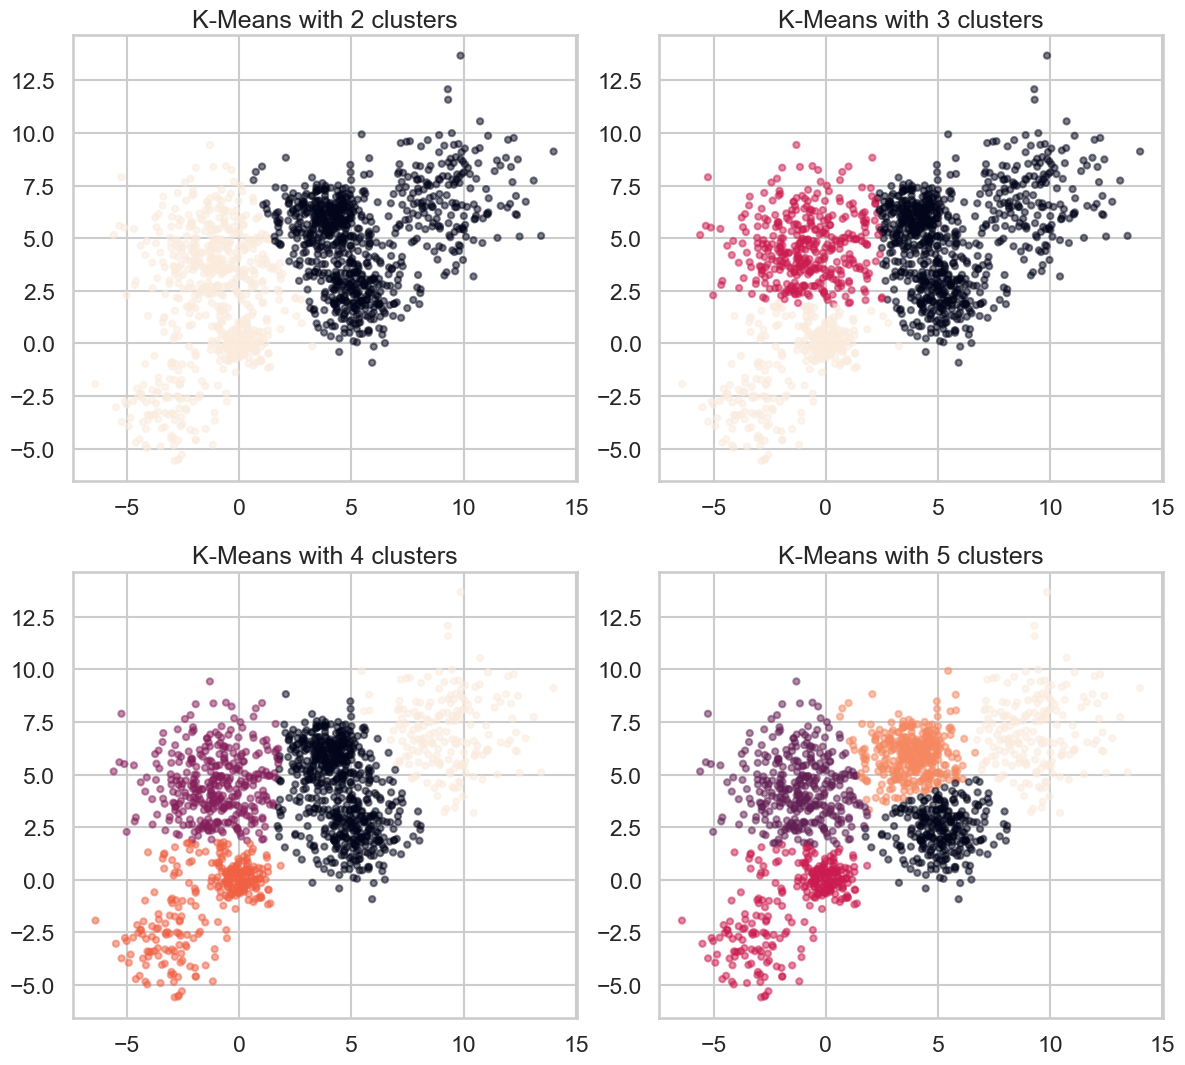

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(12, 11))  # Create a 2x2 grid of subplots
axes = axes.flatten()  # Flatten to iterate easily

for i, k in enumerate(range(2, 6)):
    model = KMeans(n_clusters=k, random_state=42)
    cluster_labels = model.fit_predict(Multi_blob_Data)

    axes[i].scatter(
        Multi_blob_Data[:, 0], Multi_blob_Data[:, 1], c=cluster_labels, alpha=0.5, s=20
    )
    axes[i].set_title(f"K-Means with {k} clusters")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### Distortion and Siluette Score 

In [75]:
ssd = []
sil_score = []
for k in range(2, 15, 1):
    model = KMeans(n_clusters=k,random_state=42)
    model.fit(Multi_blob_Data)
    cluster_labels = model.fit_predict(Multi_blob_Data)
    # Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)
    sil_score.append(silhouette_score(Multi_blob_Data, cluster_labels))

Text(0, 0.5, 'silhouette_score')

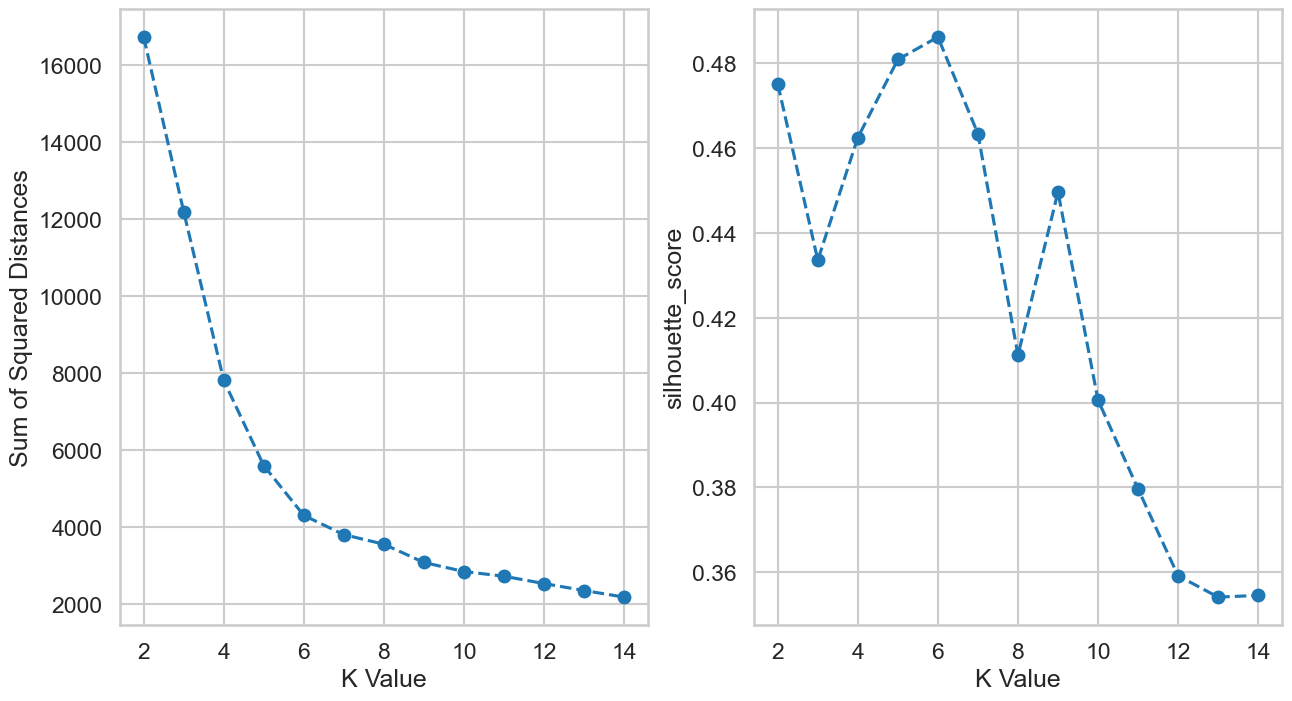

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.plot(range(2, 15, 1), ssd, "o--")
ax1.set_xlabel("K Value")
ax1.set_ylabel("Sum of Squared Distances")

ax2.plot(range(2, 15, 1), sil_score, "o--")
ax2.set_xlabel("K Value")
ax2.set_ylabel("silhouette_score")

Using the elbow method : @ k=6 countinous decrease begins to settle also the siloutte score graph indicates high score @ k=6 which further prove that the optimal is 6 clusters

Scaling the data

In [79]:
ssd = []
sil_score = []
for k in range(2, 15, 1):
    model = KMeans(n_clusters=k,random_state=42)
    model.fit(Multi_blob_Data_Scaled)
    cluster_labels = model.fit_predict(Multi_blob_Data_Scaled)
    # Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)
    sil_score.append(silhouette_score(Multi_blob_Data_Scaled, cluster_labels))

Text(0, 0.5, 'silhouette_score')

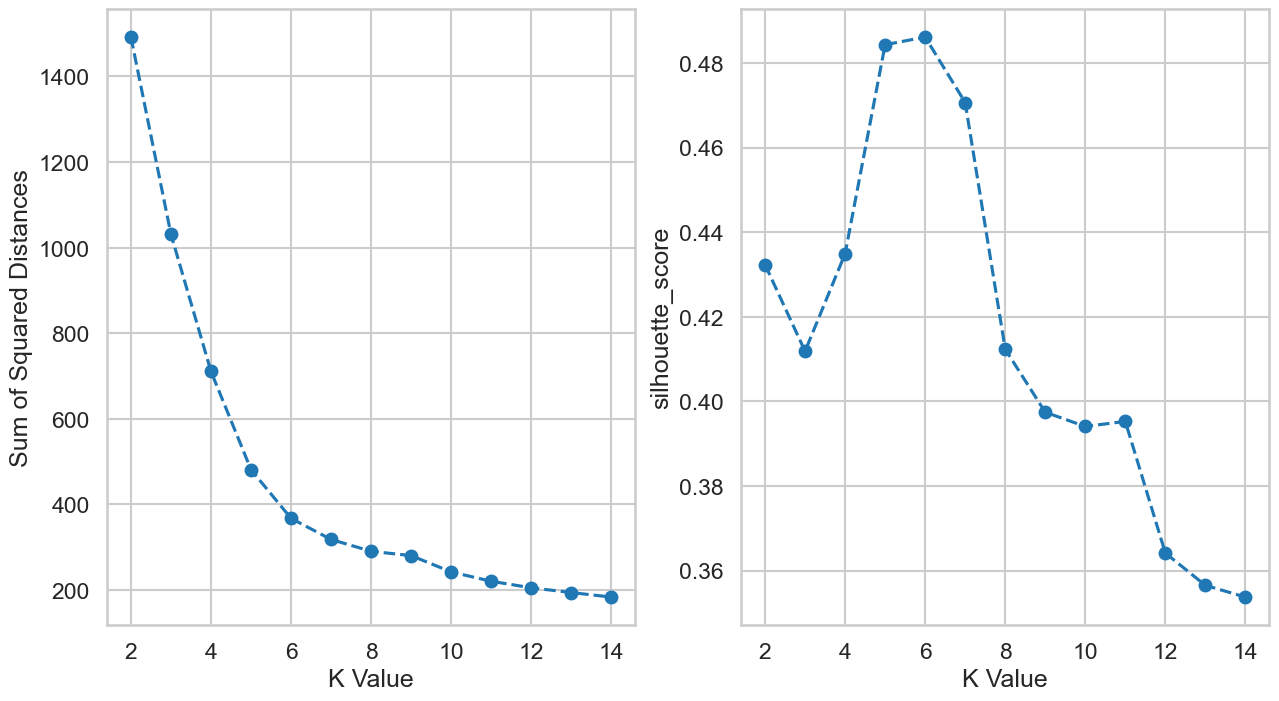

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.plot(range(2, 15, 1), ssd, "o--")
ax1.set_xlabel("K Value")
ax1.set_ylabel("Sum of Squared Distances")

ax2.plot(range(2, 15, 1), sil_score, "o--")
ax2.set_xlabel("K Value")
ax2.set_ylabel("silhouette_score")

Some observation are :
- K = 6 is the optimal K since it has the highest Siloutte score and also it is the elbow in the distortion graph
- scaling the data helps the model achieve slightly higher performance

#### Centroid initialization

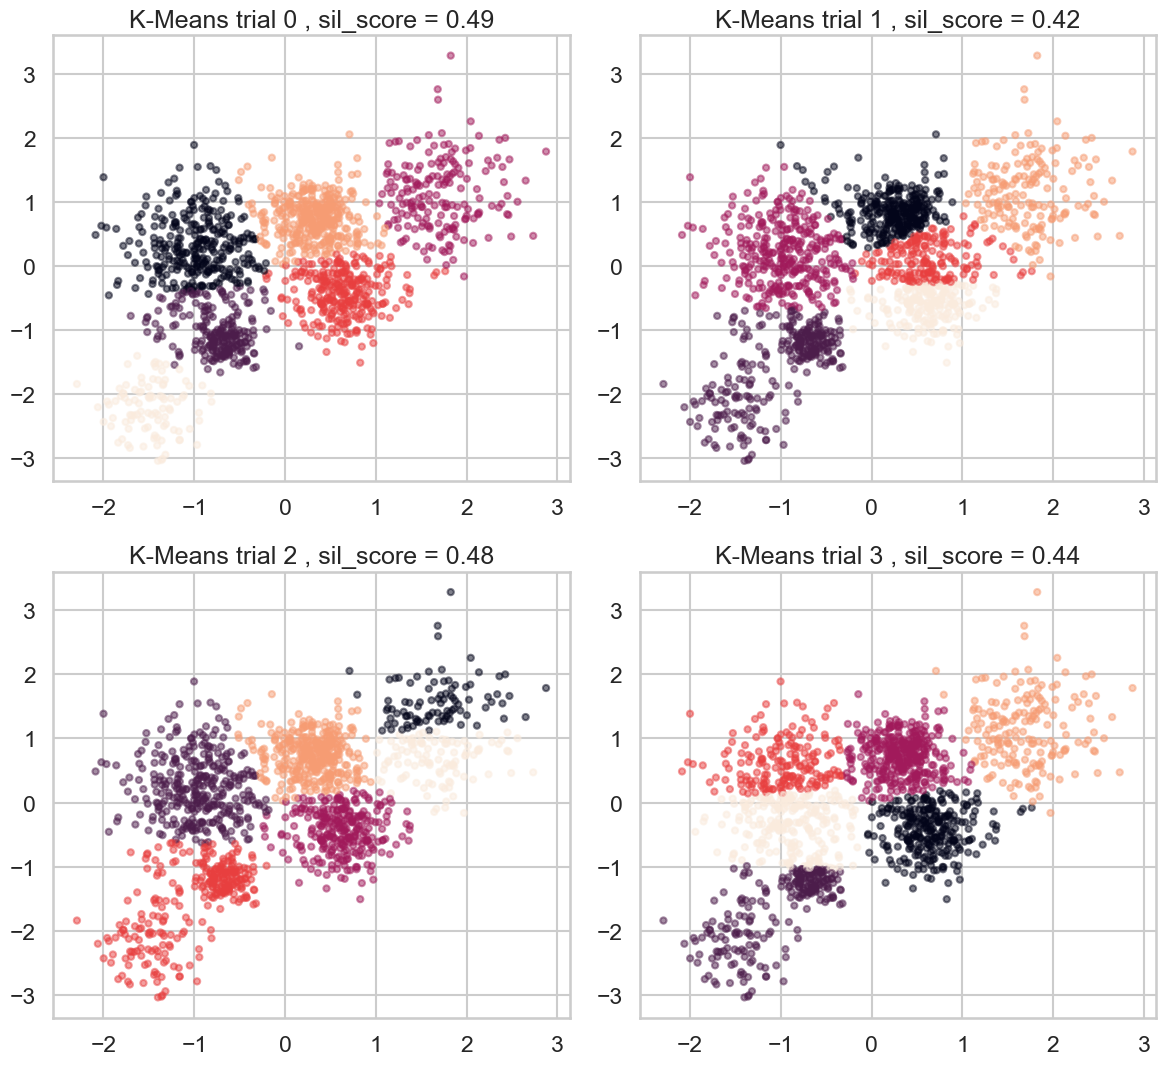

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(12, 11))  # Create a 2x2 grid of subplots
axes = axes.flatten()  # Flatten to iterate easily

for i in range(0, 4):
    model = KMeans(n_clusters=6)
    cluster_labels = model.fit_predict(Multi_blob_Data_Scaled)
    axes[i].scatter(
        Multi_blob_Data_Scaled[:, 0],
        Multi_blob_Data_Scaled[:, 1],
        c=cluster_labels,
        alpha=0.5,
        s=20,
    )
    axes[i].set_title(
        f"K-Means trial {i} , sil_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels):.2f}"
    )

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

 As shown diiferent point get clustered differntly with each kmeans trail

In [108]:
sil_score = []
for i in range(0, 20):
    model = KMeans(n_clusters=6)
    cluster_labels = model.fit_predict(Multi_blob_Data_Scaled)
    sil_score.append(round(silhouette_score(Multi_blob_Data_Scaled, cluster_labels), 2))

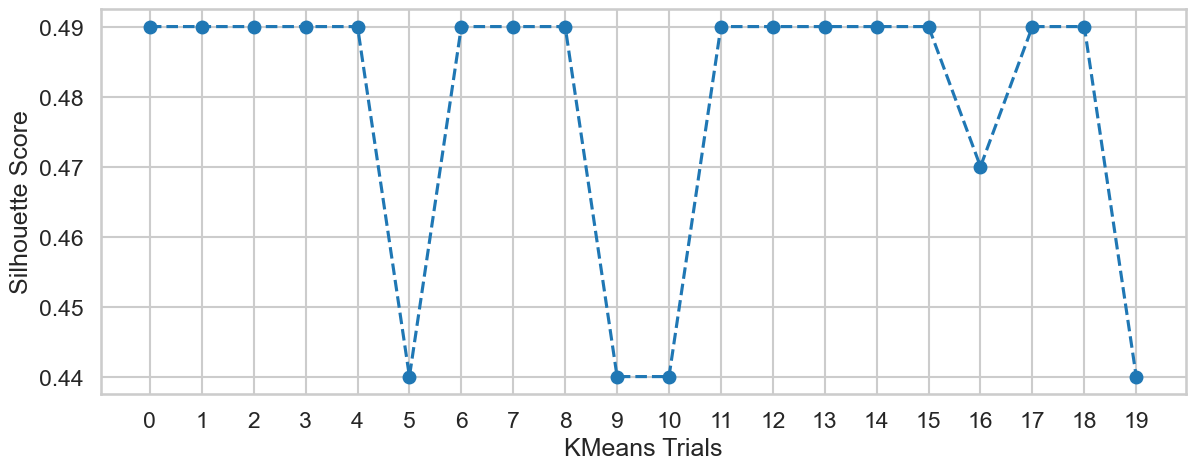

In [109]:
plt.figure(figsize=(14, 5))
plt.plot(range(0, 20, 1), sil_score, "o--")

plt.xlabel("KMeans Trials")
plt.ylabel("Silhouette Score")

plt.xticks(range(0, 20, 1))  # Force x-axis to show only integers
plt.show()

As we can see the centroid initailization affect the cluster assignment and in turns the performance of the model

- This can be solved using another variation of Kmeans which is Kmeans_plusplus
- Or we can set the randomstate to a specefic seed, it is removed here for demonestration.

In [117]:
model = KMeans(n_clusters=6)
cluster_labels = model.fit_predict(Multi_blob_Data_Scaled)
print(f"sil_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels)}")

sil_score = 0.4861099840323075


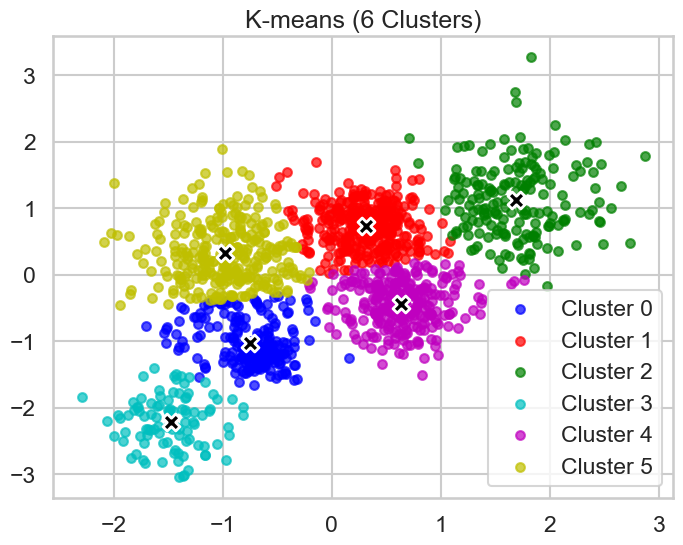

In [119]:
display_cluster(Multi_blob_Data_Scaled, cluster_labels, num_clusters=6, title="K-means")

#### Optimal Model

In [133]:
bestmodel_Kmeans = KMeans(n_clusters=6, init="k-means++",random_state=42)
cluster_labels_Kmeans_plusplus = bestmodel_Kmeans.fit_predict(Multi_blob_Data_Scaled)
silhouette_score_Kmeans = silhouette_score(
    Multi_blob_Data_Scaled, cluster_labels_Kmeans_plusplus
)
print(f"sil_score = {silhouette_score_Kmeans}")

sil_score = 0.4861099840323075


- init="k-means++" Without random_state=42: Every run may give slightly different clusters.
- init="k-means++" With random_state=42: You get consistent clusters across runs.

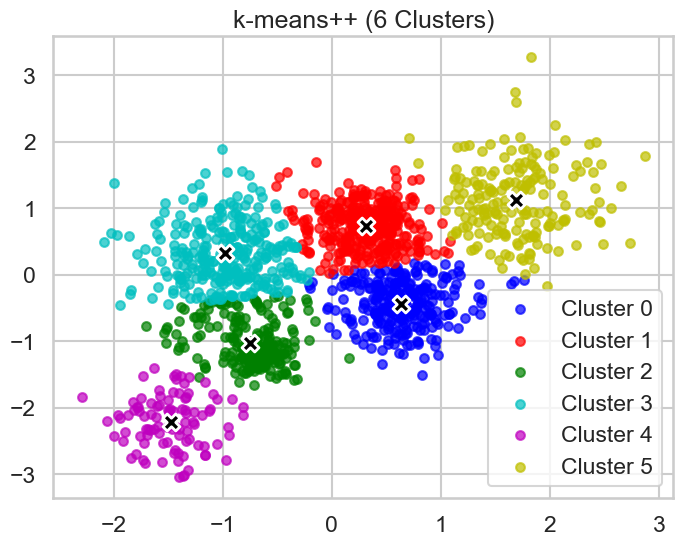

In [135]:
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels_Kmeans_plusplus,
    num_clusters=6,
    title="k-means++",
)

### Hierarchal Clustering
* Use AgglomerativeClustering function to  to cluster the above data.
* In the  AgglomerativeClustering change the following parameters:
    * Affinity (use euclidean, manhattan and cosine)
    * Linkage(try different options)
    * Distance_threshold (try different options)
* Plot the dendrograph for one trial.
* For each of these trials, calculate the silhouette_score and display the resulting clusters.  
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observation.

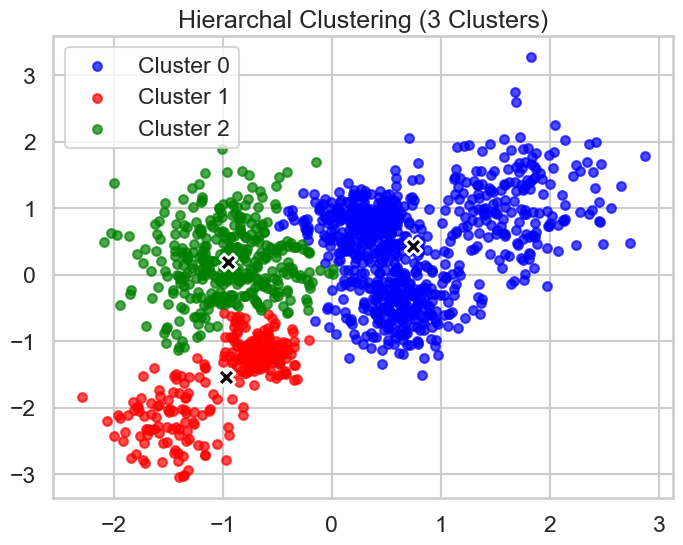


silhouette_score = 0.4088


In [138]:
model = AgglomerativeClustering(n_clusters=3)
cluster_labels = model.fit_predict(Multi_blob_Data_Scaled)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels,
    num_clusters=3,
    title="Hierarchal Clustering",
)
print()
print(
    f"silhouette_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels):.4f}"
)

#### Trails

* In the  AgglomerativeClustering change the following parameters:
    * Affinity Can be “euclidean”, “l1”, “l2”, “manhattan”, “cosine”, or “precomputed”. (use euclidean, manhattan and cosine)
    * Linkage {‘ward’, ‘complete’, ‘average’, ‘single’} (try different options)
    * Distance_threshold : The linkage distance threshold at or above which clusters will not be merged. {float} (try different options)

- L1 norm = Manhattan Distance
- L2 norm = Euclidean Distance
* Difference:
    * L1 prefers sparse solutions (used in LASSO).
    * L2 penalizes large errors more (used in Ridge Regression).

##### Affinity = Metric

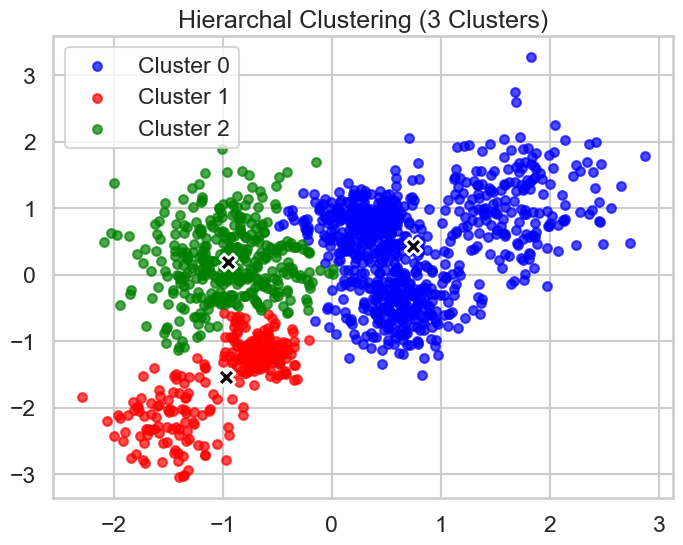


silhouette_score = 0.4088


In [76]:
model1 = AgglomerativeClustering(n_clusters=3, metric="euclidean")
cluster_labels1 = model1.fit_predict(Multi_blob_Data_Scaled)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels1,
    num_clusters=3,
    title="Hierarchal Clustering",
)
print()
print(
    f"silhouette_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels1):.4f}"
)

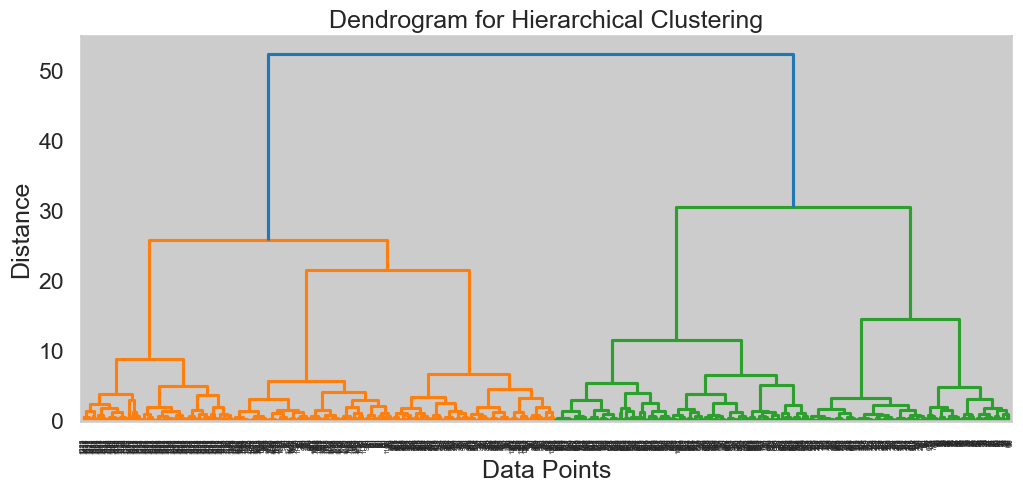

In [78]:
# Compute the linkage matrix
Z = linkage(Multi_blob_Data_Scaled, method="ward")
# Plot the dendrogram
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode="level", p=10)  # p=10 limits the number of levels displayed
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

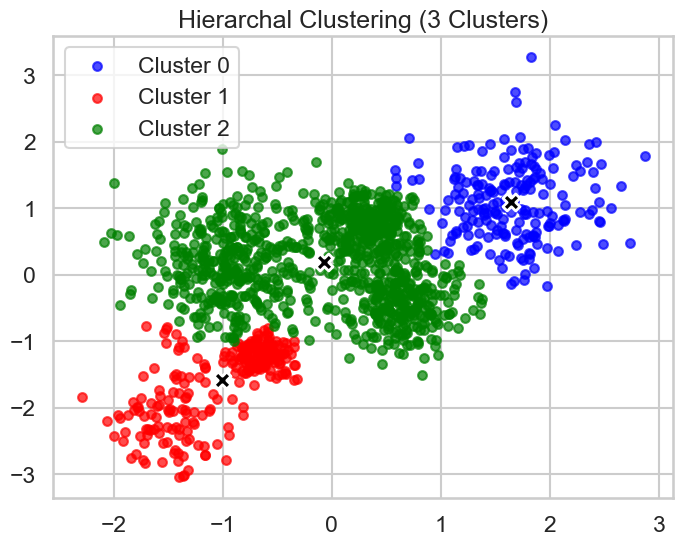


silhouette_score = 0.3575


In [80]:
model2 = AgglomerativeClustering(n_clusters=3, metric="manhattan", linkage="average")
cluster_labels2 = model2.fit_predict(Multi_blob_Data_Scaled)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels2,
    num_clusters=3,
    title="Hierarchal Clustering",
)
print()
print(
    f"silhouette_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels2):.4f}"
)

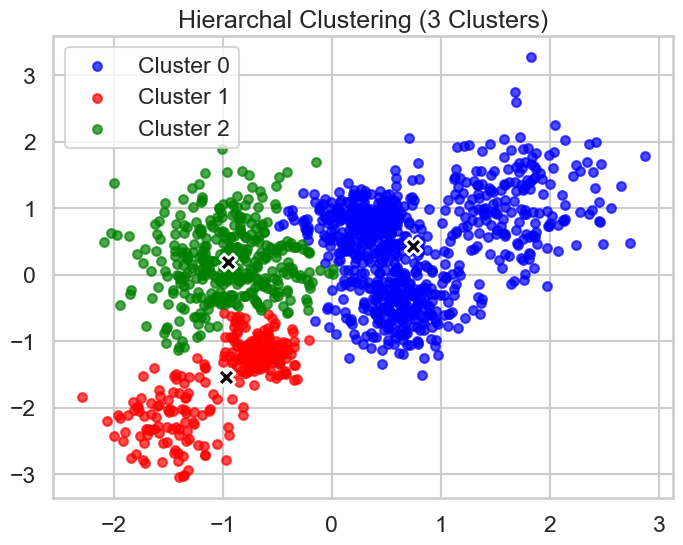


silhouette_score = 0.3292


In [82]:
model3 = AgglomerativeClustering(n_clusters=3, metric="cosine", linkage="average")
cluster_labels3 = model3.fit_predict(Multi_blob_Data_Scaled)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels1,
    num_clusters=3,
    title="Hierarchal Clustering",
)
print()
print(
    f"silhouette_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels3):.4f}"
)

##### Linkage

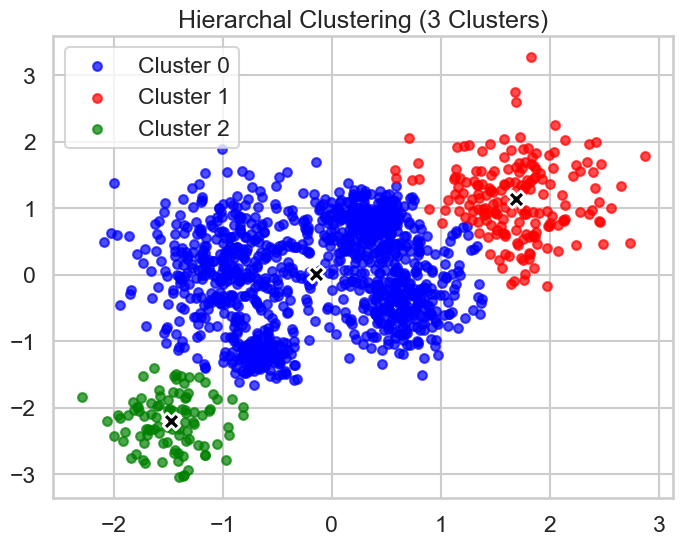


silhouette_score = 0.3188


In [85]:
model1 = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="complete")
cluster_labels1 = model1.fit_predict(Multi_blob_Data_Scaled)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels1,
    num_clusters=3,
    title="Hierarchal Clustering",
)
print()
print(
    f"silhouette_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels1):.4f}"
)

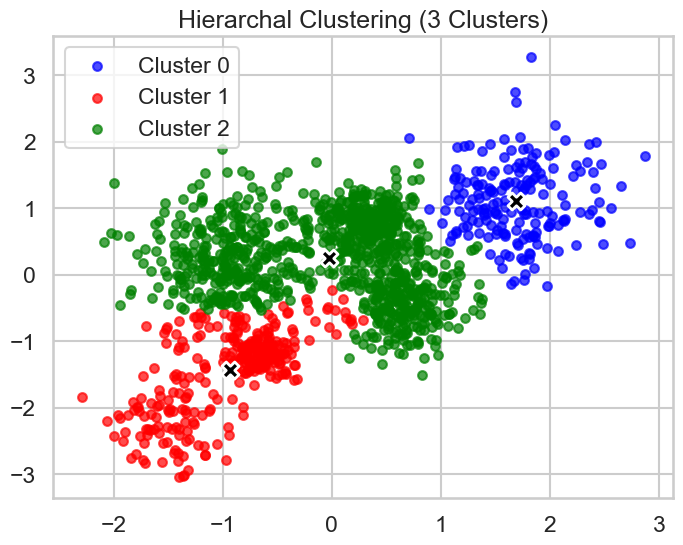


silhouette_score = 0.3622


In [87]:
model2 = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="average")
cluster_labels2 = model2.fit_predict(Multi_blob_Data_Scaled)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels2,
    num_clusters=3,
    title="Hierarchal Clustering",
)
print()
print(
    f"silhouette_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels2):.4f}"
)

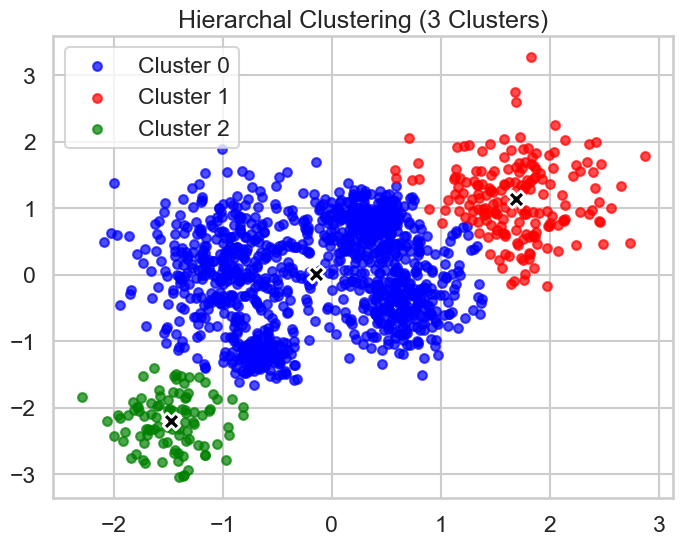


silhouette_score = 0.2576


In [88]:
model3 = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="single")
cluster_labels3 = model3.fit_predict(Multi_blob_Data_Scaled)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels1,
    num_clusters=3,
    title="Hierarchal Clustering",
)
print()
print(
    f"silhouette_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels3):.4f}"
)

##### Distance_threshold

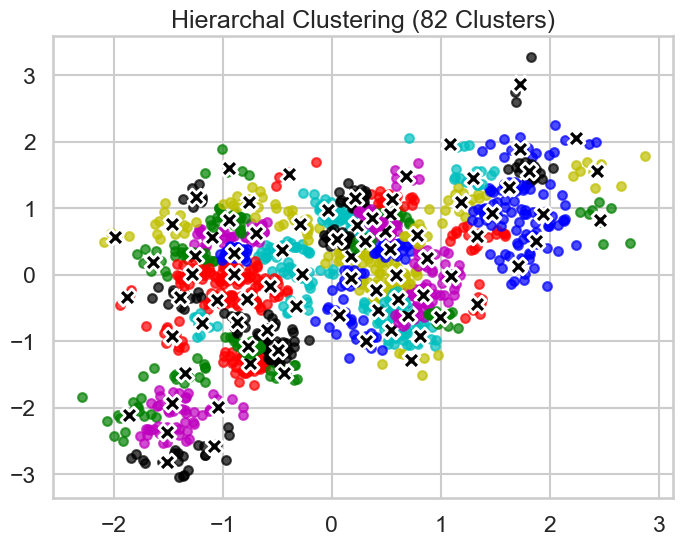


silhouette_score = 0.3331


In [91]:
model1 = AgglomerativeClustering(n_clusters=None, distance_threshold=1)
cluster_labels1 = model1.fit_predict(Multi_blob_Data_Scaled)
c = max(cluster_labels1)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels1,
    num_clusters=c,
    title="Hierarchal Clustering",
    legend=False,
)
print()
print(
    f"silhouette_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels1):.4f}"
)

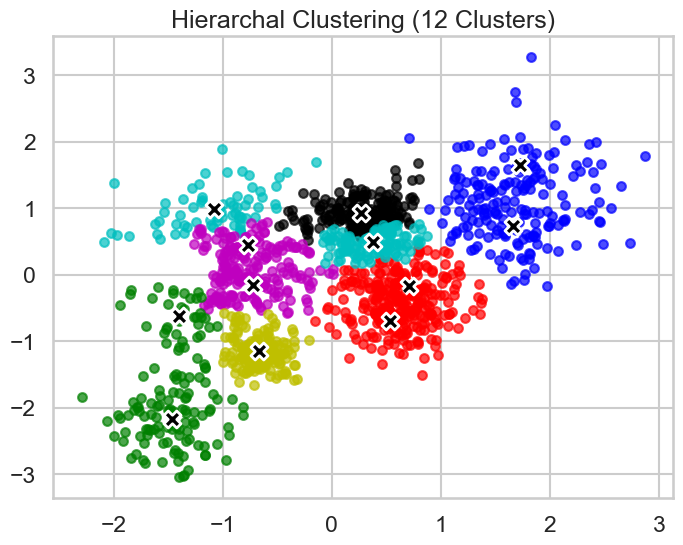


silhouette_score = 0.3336


In [93]:
model1 = AgglomerativeClustering(n_clusters=None, distance_threshold=5)
cluster_labels1 = model1.fit_predict(Multi_blob_Data_Scaled)
c = max(cluster_labels1)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels1,
    num_clusters=c,
    title="Hierarchal Clustering",
    legend=False,
)
print()
print(
    f"silhouette_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels1):.4f}"
)

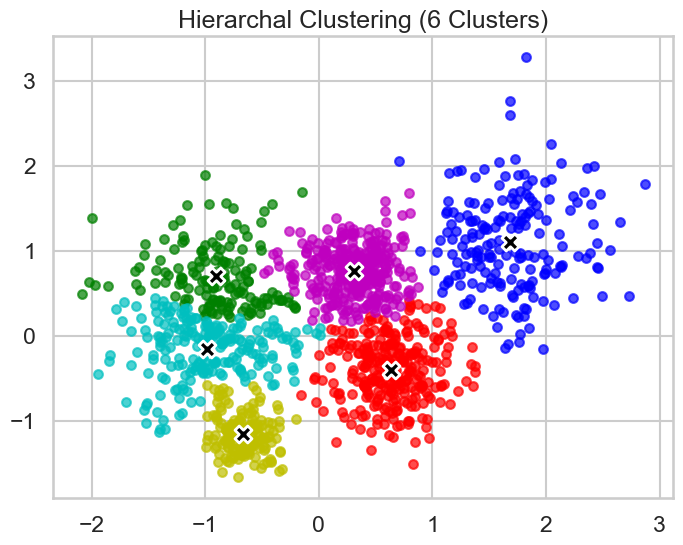


silhouette_score = 0.4549


In [94]:
model1 = AgglomerativeClustering(n_clusters=None, distance_threshold=10)
cluster_labels1 = model1.fit_predict(Multi_blob_Data_Scaled)
c = max(cluster_labels1)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels1,
    num_clusters=c,
    title="Hierarchal Clustering",
    legend=False,
)
print()
print(
    f"silhouette_score = {silhouette_score(Multi_blob_Data_Scaled,cluster_labels1):.4f}"
)

Increasing the distance threshold, decreases the no. of clusters

#### Tuning
These parameters will be tuned (Grid search):
- linkage
- metric = affinity
- n_clusters

In [99]:
linkage_list = ["average", "single", "complete"]
affinity_list = ["euclidean", "manhattan", "cosine"]
n_clusters_range = np.arange(2, 20)
# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=["model", "n_clusters", "affinity", "linkage", "silhouette_score"]
)

# Variables to track the best model
best_silhouette = -1
best_n_clusters = None
best_affinity = None
best_linkage = None

# Loop through different cluster numbers, affinity, and linkage types
for n_clusters in n_clusters_range:
    for affinity in affinity_list:
        for linkage in linkage_list:
            try:
                # Train the model
                model = AgglomerativeClustering(
                    n_clusters=n_clusters, metric=affinity, linkage=linkage
                )
                model.fit(Multi_blob_Data_Scaled)

                # Compute silhouette score
                silhouette = silhouette_score(Multi_blob_Data_Scaled, model.labels_)

                # Append results to DataFrame
                new_row = pd.DataFrame(
                    [
                        {
                            "model": model,
                            "n_clusters": n_clusters,
                            "affinity": affinity,
                            "linkage": linkage,
                            "silhouette_score": silhouette,
                        }
                    ]
                )
                results_df = pd.concat([results_df, new_row], ignore_index=True)

                # Print progress
                # print(f"Silhouette Score for {n_clusters} clusters, affinity={affinity}, linkage={linkage}: {silhouette:.4f}")

                # Update best model
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_n_clusters = n_clusters
                    best_affinity = affinity
                    best_linkage = linkage

            except Exception as e:
                print(
                    f"Skipping: n_clusters={n_clusters}, affinity={affinity}, linkage={linkage} due to error: {e}"
                )

# Get the index of the best model from the DataFrame
best_model_index = results_df[
    (results_df["n_clusters"] == best_n_clusters)
    & (results_df["affinity"] == best_affinity)
    & (results_df["linkage"] == best_linkage)
].index[0]

# Print the best model details including index
print(f"\nBest Agglomerative Clustering Model (Index {best_model_index} in DataFrame):")
print(f" - n_clusters: {best_n_clusters}")
print(f" - Affinity: {best_affinity}")
print(f" - Linkage: {best_linkage}")
print(f" - Silhouette Score: {best_silhouette:.4f}")


Best Agglomerative Clustering Model (Index 6 in DataFrame):
 - n_clusters: 2
 - Affinity: cosine
 - Linkage: average
 - Silhouette Score: 0.4236


In [100]:
results_df.sort_values("silhouette_score", ascending=False).head(10)

model n_clusters   affinity  \
6   AgglomerativeClustering(linkage='average', met...          2     cosine   
27  AgglomerativeClustering(linkage='average', n_c...          5  euclidean   
66  AgglomerativeClustering(linkage='average', met...          9  manhattan   
63  AgglomerativeClustering(linkage='average', n_c...          9  euclidean   
75  AgglomerativeClustering(linkage='average', met...         10  manhattan   
24  AgglomerativeClustering(linkage='average', met...          4     cosine   
30  AgglomerativeClustering(linkage='average', met...          5  manhattan   
57  AgglomerativeClustering(linkage='average', met...          8  manhattan   
36  AgglomerativeClustering(linkage='average', n_c...          6  euclidean   
3   AgglomerativeClustering(linkage='average', met...          2  manhattan   

    linkage  silhouette_score  
6   average          0.423607  
27  average          0.419060  
66  average          0.417663  
63  average          0.417475  
75  average          0.414984  
24  average          0.414747  
30  average          0.412069  
57  average          0.410118  
36  average          0.410098  
3   average          0.404102

#### Optimal

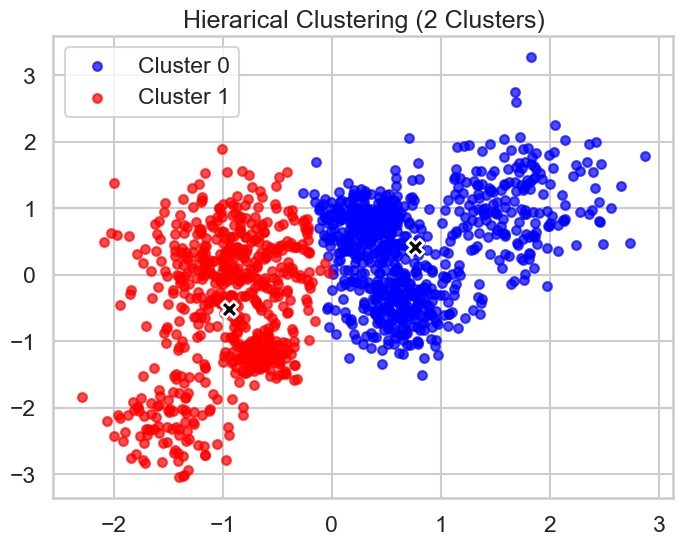

0.423606851876823

In [104]:
bestmodel_Hierarical = AgglomerativeClustering(
    n_clusters=best_n_clusters, metric=best_affinity, linkage=best_linkage
)
cluster_labels_Hierarical = bestmodel_Hierarical.fit_predict(Multi_blob_Data_Scaled)
silhouette_score_Hierarical = silhouette_score(
    Multi_blob_Data_Scaled, cluster_labels_Hierarical
)
display_cluster(
    Multi_blob_Data_Scaled,
    cluster_labels_Hierarical,
    num_clusters=2,
    title="Hierarical Clustering",
)
silhouette_score_Hierarical

The optimal parameters found were 
 - n_clusters: 2
 - Affinity: cosine
 - Linkage: average
 - Silhouette Score: 0.4236

which may appear good at first glance due to the silhouette Score but we already know that the data should be clustered into 6 clusters which came 9th place in terms of silhouette score.


### DBScan
* Use DBScan function to  to cluster the above data. 
* In the  DBscan change the following parameters: 
    * EPS (from 0.1 to 3)
    * Min_samples (from 5 to 25)
    * Another option: Lookup K-Distance graph method
* Plot the silhouette_score versus the variation in the EPS and the min_samples.
* Plot the resulting Clusters in this case. 
* Find the set of paramters that would find result in the best silhouette_score and store this score for later comparison with other clustering techniques. 
* Record your observations and comments. 

In [110]:
dbscan = DBSCAN()
cluster_labels = dbscan.fit_predict(Multi_blob_Data_Scaled)
unique_clusters = set(cluster_labels) - {-1}  # Exclude noise points
if len(unique_clusters) > 1:  # Ensure at least 2 clusters exist
    score = silhouette_score(Multi_blob_Data_Scaled, cluster_labels)
    print(f"silhouette_score : {score}")
else:
    print(f"No Score since no. of clusters = 1 ")

No Score since no. of clusters = 1 


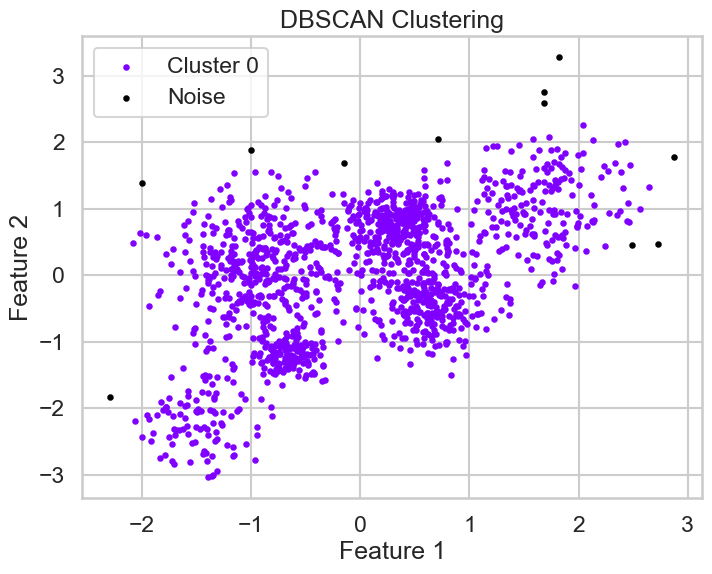

In [112]:
plot_dbscan(Multi_blob_Data_Scaled)

#### Varing Parameters
- Varing EPS (from 0.1 to 3)
- Varing Min_samples (from 5 to 25)

##### EPS

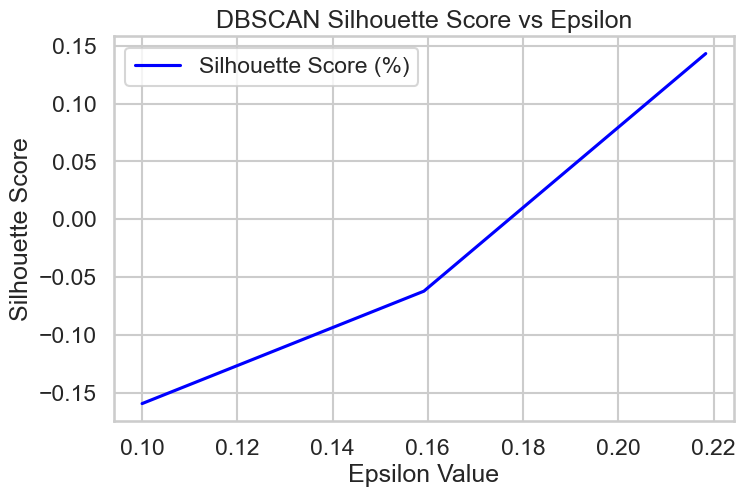

In [138]:
eps_values = np.linspace(0.1, 3, 50)
sil = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=4)
    cluster_labels = dbscan.fit_predict(Multi_blob_Data_Scaled)
    # Calculate silhouette score only if at least 2 clusters exist
    unique_clusters = set(cluster_labels) - {-1}  # Ignore noise points (-1)
    if len(unique_clusters) > 1:
        sil.append(silhouette_score(Multi_blob_Data_Scaled, cluster_labels))
    else:
        sil.append(np.nan)  # Store NaN when silhouette score is not valid

plt.figure(figsize=(8, 5))
sns.lineplot(x=eps_values, y=sil, label="Silhouette Score (%)", color="blue")
# sns.lineplot(x=eps_values, y=outlier_percent, label="Outlier Percentage (%)", color="red")
plt.legend()
plt.ylabel("Silhouette Score")
plt.xlabel("Epsilon Value")
plt.title("DBSCAN Silhouette Score vs Epsilon")
plt.show()

##### min_samples

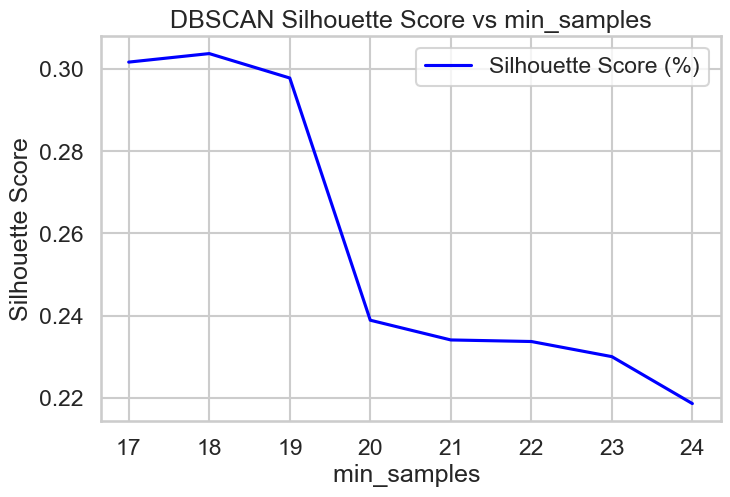

In [130]:
min_samples = np.arange(4, 25)
sil = []

for samples in min_samples:
    dbscan = DBSCAN(eps=0.3, min_samples=samples)
    cluster_labels = dbscan.fit_predict(Multi_blob_Data_Scaled)
    # Calculate silhouette score only if at least 2 clusters exist
    unique_clusters = set(cluster_labels) - {-1}  # Ignore noise points (-1)
    if len(unique_clusters) > 1:
        sil.append(silhouette_score(Multi_blob_Data_Scaled, cluster_labels))
    else:
        sil.append(np.nan)  # Store NaN when silhouette score is not valid

plt.figure(figsize=(8, 5))
sns.lineplot(x=min_samples, y=sil, label="Silhouette Score (%)", color="blue")
# sns.lineplot(x=eps_values, y=outlier_percent, label="Outlier Percentage (%)", color="red")
plt.legend()
plt.ylabel("Silhouette Score")
plt.xlabel("min_samples ")
plt.title("DBSCAN Silhouette Score vs min_samples")
plt.xticks()
plt.show()

##### K-Distance graph
- Compute the distance to the k-th nearest neighbor (k = min_samples).
- Plot these distances and look for an "elbow" point (a sharp change in slope).

In [140]:
from sklearn.neighbors import NearestNeighbors

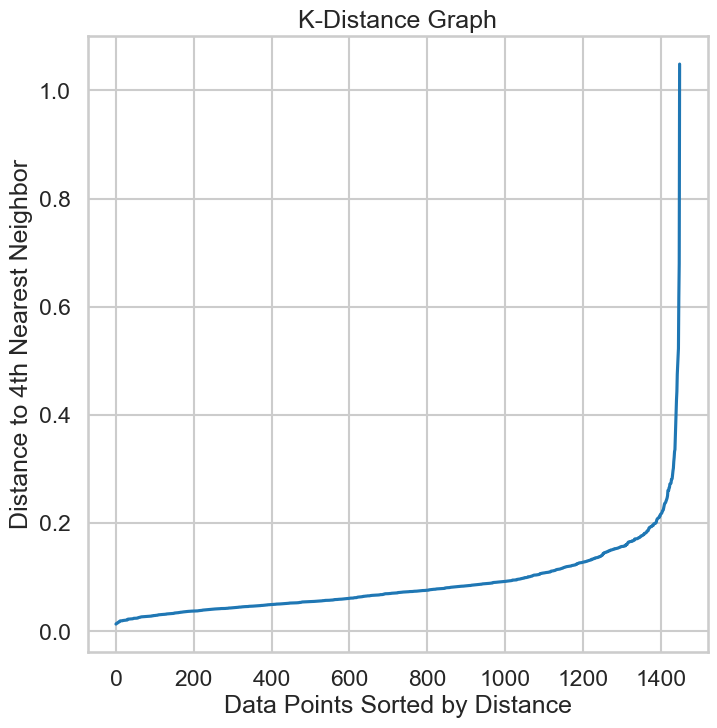

In [142]:
k = 4  # MIn samples = 4 since we have 2 features
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(Multi_blob_Data_Scaled)
distances, _ = neigh.kneighbors(Multi_blob_Data_Scaled)

# Sort distances for the k-th nearest neighbor
sorted_distances = np.sort(distances[:, -1])
plt.plot(sorted_distances)
plt.ylabel("Distance to {}th Nearest Neighbor".format(k))
plt.xlabel("Data Points Sorted by Distance")
plt.title("K-Distance Graph")
plt.show()

From the graph eps around 0.2 is good.

#### Tuning
These parameters will be tuned (Grid search):
- eps
- min_samples

In [146]:
# Define ranges for eps and min_samples
eps_values = np.arange(0.05, 2, 0.05)  # Adjust based on the K-distance plot
min_samples_values = range(2, 15, 2)

best_score = -1
best_params = {}

# Grid search over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(Multi_blob_Data_Scaled)

        unique_clusters = set(labels) - {-1}  # Exclude noise points
        if len(unique_clusters) > 1:  # Ensure at least 2 clusters exist
            score = silhouette_score(Multi_blob_Data_Scaled, labels)
            if score > best_score:
                best_score = score
                best_params = {"eps": eps, "min_samples": min_samples}


print(
    f"Best Parameters: eps={best_params['eps']:.3f}, min_samples={best_params['min_samples']}"
)
print(f"Best Silhouette Score: {best_score:.4f}")

Best Parameters: eps=0.450, min_samples=2
Best Silhouette Score: 0.3688


#### Optimal

In [149]:
silhouette_score_dpscan = best_score

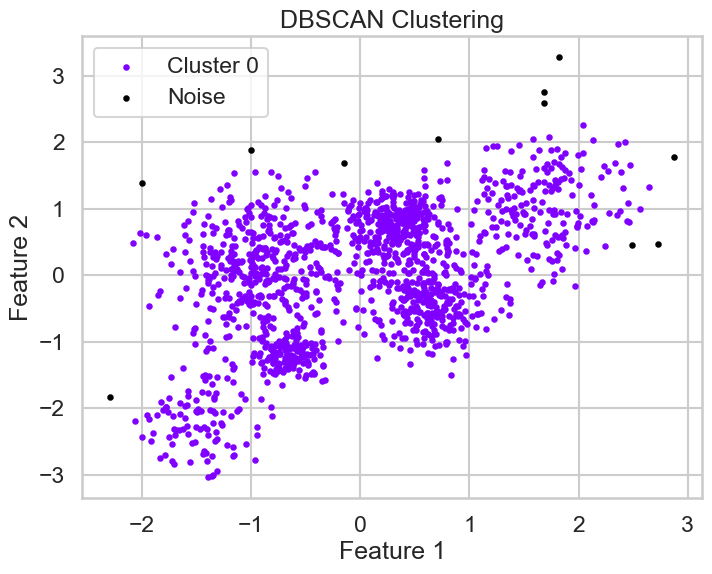

In [151]:
plot_dbscan(Multi_blob_Data_Scaled)

- We didnot need to tune the model since the first trail was already Optiomal
- As we can see we cant take this model into consideration since the the model didnot cluster the data it only detected the ouliers

### Conclusion

In [163]:
print("Silouette_score : ")
print(
    f"Kmeans: {silhouette_score_Kmeans:.4f} , Hierarchal: {silhouette_score_Hierarical:.4f} , DBScan : {silhouette_score_dpscan:.4f}"
)
print()
print("num_clusters : ")
print(
    f"Kmeans: 6 clusters , Hierarchal: 2 clusters, DBScan : 1 cluster"
)

Silouette_score : 
Kmeans: 0.4863 , Hierarchal: 0.4236 , DBScan : 0.3688

num_clusters : 
Kmeans: 6 clusters , Hierarchal: 2 clusters, DBScan : 1 cluster


- Its clear that the choise here for clustering should be Kmeans since it achieved the highest siluette score.
- Another point is that we already know the data should be clustered into 6 clusters so although Hierarchal Silouette_score is high , it clustered the data wrong.
- Grid search was used to tune these models since the num_parameters for each model is small so its not that computationaly expensive.

## iris data set 
The iris data set is test data set that is part of the Sklearn module 
which contains 150 records each with 4 features. All the features are represented by real numbers. 

The data represents three classes. 


In [191]:
from sklearn.datasets import load_iris

iris_data = load_iris()
iris_data.target[[10, 25, 50]]
# array([0, 0, 1])
list(iris_data.target_names)
["setosa", "versicolor", "virginica"]

['setosa', 'versicolor', 'virginica']

* Repeat all the above clustering approaches and steps on the above data. 
* Comment on the effect of scaling on clustering this dataset. Show the difference between clustering the data with and without   scaling.
* Compare between the different clustering approaches. 
* Is your clustering outcome consistent with the labels?

In [194]:
iris_data

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [196]:
iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]

In [198]:
iris_scaled = StandardScaler().fit_transform(iris_df)

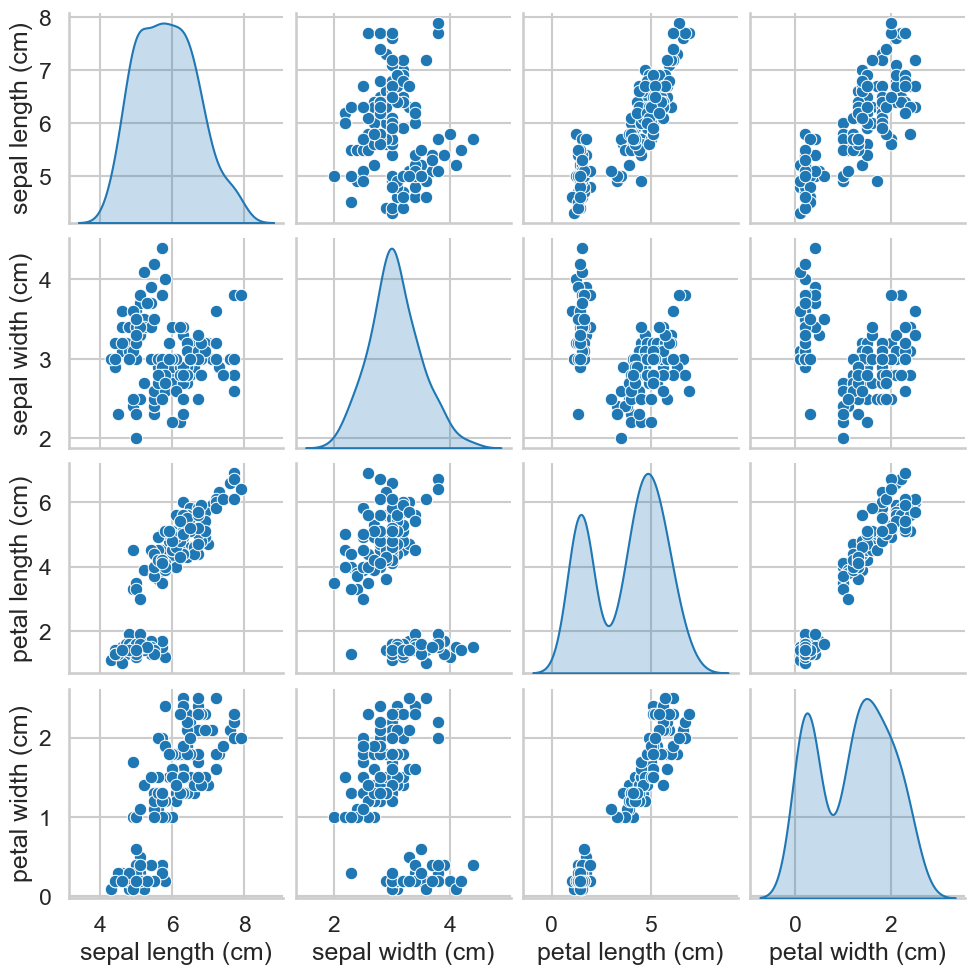

In [176]:
sns.pairplot(iris_df, diag_kind="kde", palette="Set2")
plt.show()

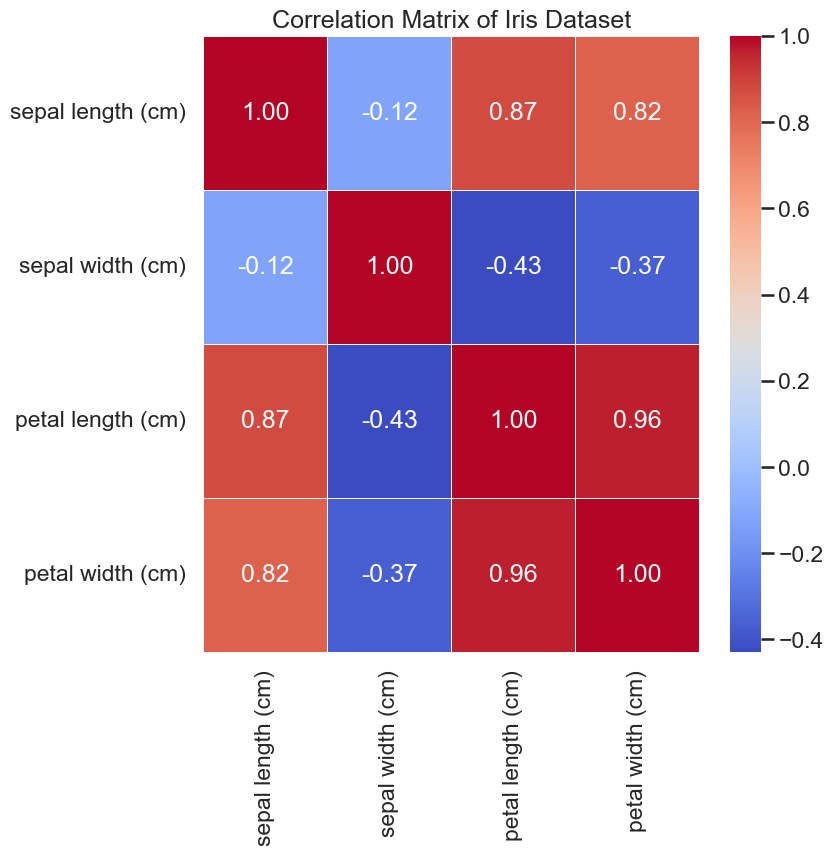

In [187]:
corr=iris_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Iris Dataset")
plt.show()

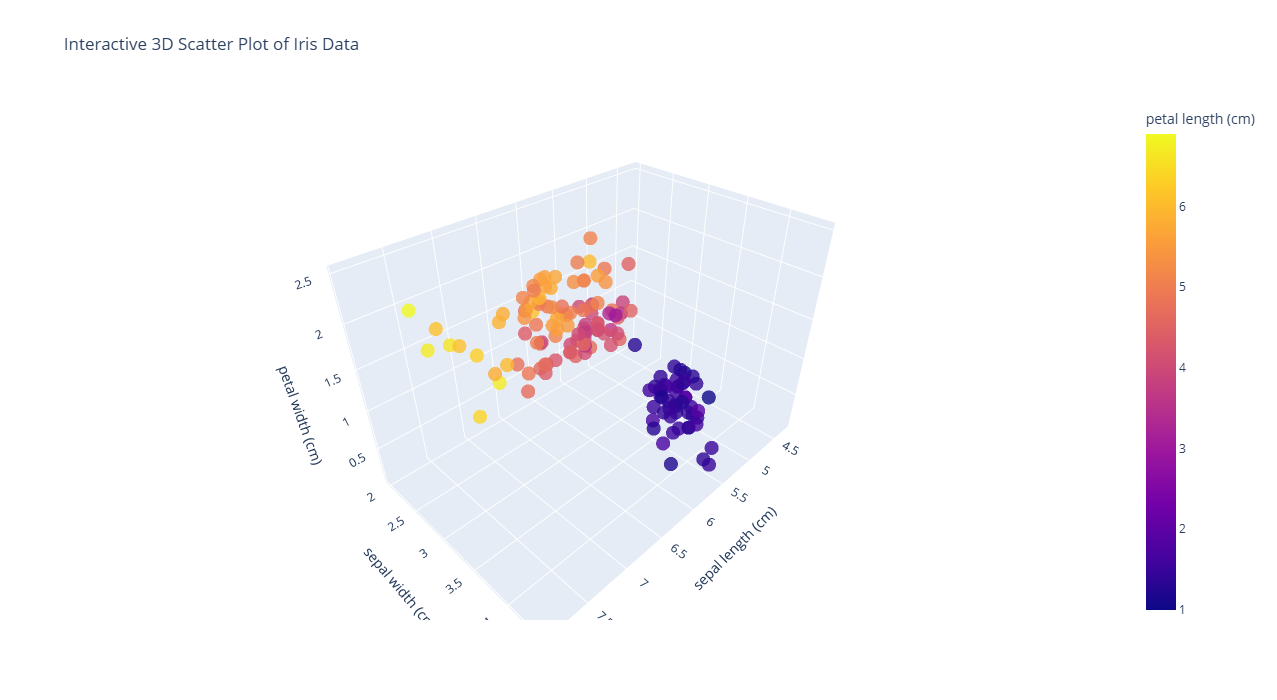

In [198]:
# Select three columns for 3D plotting
fig = px.scatter_3d(
    iris_df, 
    x="sepal length (cm)", 
    y="sepal width (cm)", 
    z="petal width (cm)", 
    color="petal length (cm)",  # Using the third column for color
    title="Interactive 3D Scatter Plot of Iris Data",
    opacity=0.8
)
fig.update_layout(
    height=700   # Increase height
)

# Show the plot
fig.show()

### Kmeans

#### Tunning

In [162]:
best_k = None
ssd = []
sil_score = []
best_score = -1
for k in range(2, 10):  # Min 2 clusters for silhouette score
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    labels = kmeans.fit_predict(iris_df)
    score = silhouette_score(iris_df, labels)
    ssd.append(kmeans.inertia_)
    sil_score.append(score)
    print(f'K={k}, Silhouette Score: {score:.3f}')
    
    if score > best_score:
        best_score = score
        best_k = k

print(f'Optimal Number of Clusters (based on Silhouette score): {best_k}')

K=2, Silhouette Score: 0.681
K=3, Silhouette Score: 0.551
K=4, Silhouette Score: 0.498
K=5, Silhouette Score: 0.493
K=6, Silhouette Score: 0.368
K=7, Silhouette Score: 0.354
K=8, Silhouette Score: 0.345
K=9, Silhouette Score: 0.316
Optimal Number of Clusters (based on Silhouette score): 2


Text(0, 0.5, 'silhouette_score')

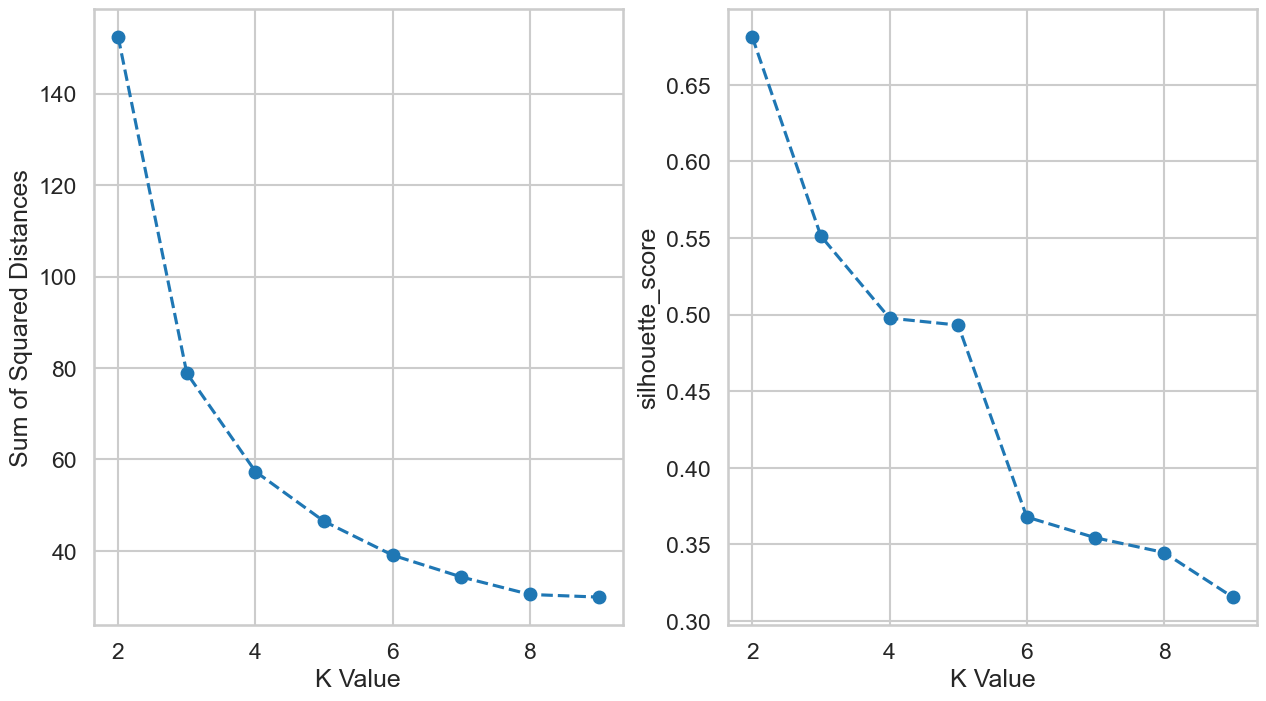

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.plot(range(2, 10, 1), ssd, "o--")
ax1.set_xlabel("K Value")
ax1.set_ylabel("Sum of Squared Distances")
ax2.plot(range(2, 10, 1), sil_score, "o--")
ax2.set_xlabel("K Value")
ax2.set_ylabel("silhouette_score")

- The curve (left graph) drops sharply from K=2 to K=3 and then flattens more gradually from K=3 to K=4, 5, etc.
- This drop is clearly seen in the next graph (diff plot) where at x=2 (corressponds to k=3) the diff between it and x=1 is much greater than that between itself and x=3
- Silhouette Score plot (right graph) also suggests K=3, as the score drops significantly after K=3.

[152.3479517603579, 78.8556658259773, 57.35088021295475, 46.472230158730156, 39.066035353535355, 34.3058152958153, 30.476222943722952, 29.90624665913797]


Text(0.5, 1.0, 'diff plot')

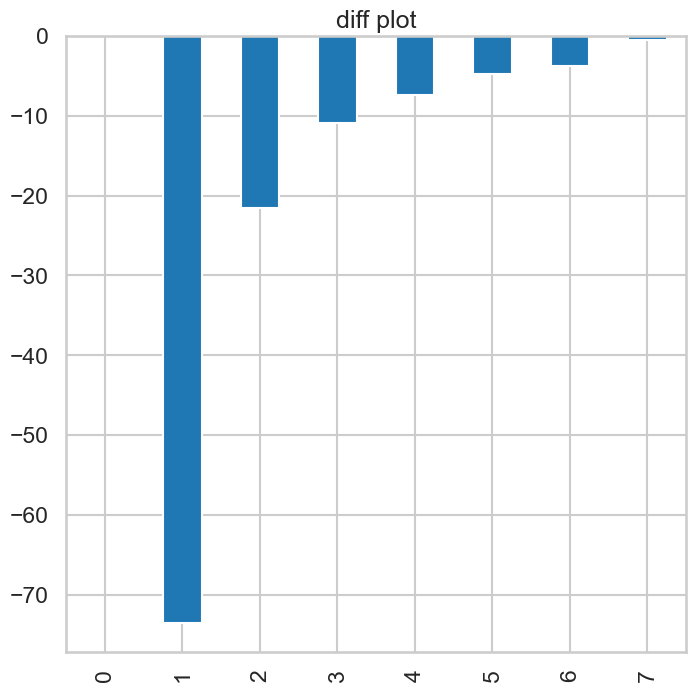

In [156]:
print(ssd)
pd.Series(ssd).diff().plot(kind="bar")
plt.title("diff plot")

#### Optimal
So the best model bassed on the previous figures is with k=3

In [166]:
best_k=3
best_model_kmeans = KMeans(n_clusters=best_k, init="k-means++", random_state=42)
labels = best_model_kmeans.fit_predict(iris_df)
best_score_kmeans = silhouette_score(iris_df, labels)
print(f'K={best_k}, Silhouette Score: {best_score_kmeans:.3f}')

K=3, Silhouette Score: 0.551


### Hierarchal Clustering

#### Scaled vs Unscaled

In [208]:
model = AgglomerativeClustering(n_clusters=3)
cluster_labels = model.fit_predict(iris_df)
print(f"silhouette_score = {silhouette_score(iris_df,cluster_labels):.4f}")

silhouette_score = 0.5543


In [228]:
model = AgglomerativeClustering(n_clusters=3)
cluster_labels = model.fit_predict(iris_scaled)
print(f"silhouette_score = {silhouette_score(iris_scaled,cluster_labels):.4f}")

silhouette_score = 0.4467


As shown here scaling (using standardization) in this example degrades performance.

#### Dendrogram

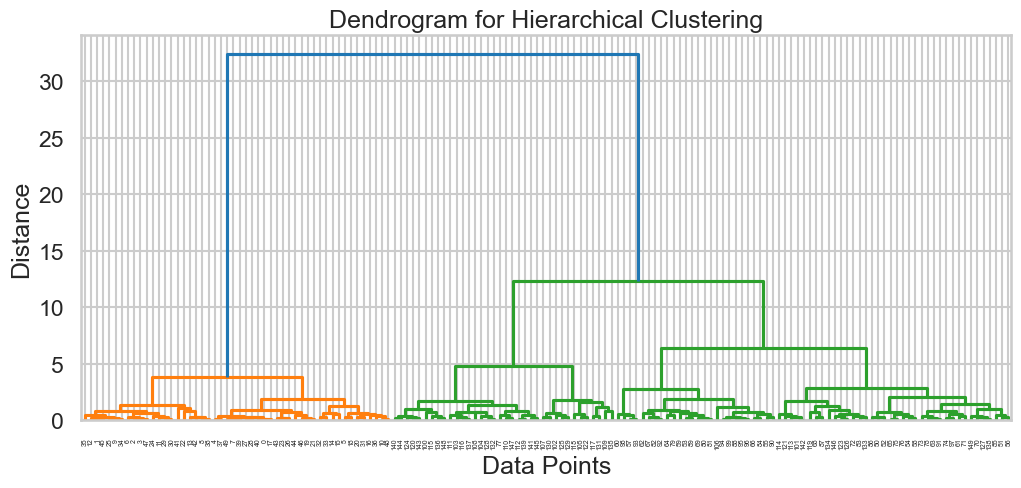

In [220]:
# Compute the linkage matrix
Z = linkage(iris_df, method="ward")
# Plot the dendrogram
plt.figure(figsize=(12, 5))
dendrogram(Z, truncate_mode="level", p=10)  # p=10 limits the number of levels displayed
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

#### Tuning

In [ ]:
- Unlike Silhouette Score, DB Score does not require well-separated clusters.
- It evaluates both compactness & separation of clusters.
- Lower DB Score = Better clustering.

In [210]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
import numpy as np

# Define parameters to tune
linkage_list = ["average", "single", "complete", "ward"]
affinity_list = ["euclidean", "manhattan", "cosine"]
n_clusters_range = np.arange(2, 16)

# Create an empty DataFrame to store results
results_df = pd.DataFrame(
    columns=["model", "n_clusters", "affinity", "linkage", "silhouette_score", "db_score"]
)

# Variables to track the best models
best_silhouette = -1  # Higher is better
best_db_score = float("inf")  # Lower is better

best_silhouette_model = None
best_db_model = None

# Loop through different cluster numbers, affinity, and linkage types
for n_clusters in n_clusters_range:
    for affinity in affinity_list:
        for linkage in linkage_list:
            if linkage == "ward" and affinity != "euclidean":
                continue  # Ward linkage only works with Euclidean distance
            try:
                # Train the model
                model = AgglomerativeClustering(
                    n_clusters=n_clusters, metric=affinity, linkage=linkage
                )
                model.fit(iris_df)

                # Compute scores
                silhouette = silhouette_score(iris_df, model.labels_)
                db_score = davies_bouldin_score(iris_df, model.labels_)

                # Append results to DataFrame
                new_row = pd.DataFrame(
                    [
                        {
                            "model": model,
                            "n_clusters": n_clusters,
                            "affinity": affinity,
                            "linkage": linkage,
                            "silhouette_score": silhouette,
                            "db_score": db_score,
                        }
                    ]
                )
                results_df = pd.concat([results_df, new_row], ignore_index=True)

                # Update best models
                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_silhouette_model = {
                        "n_clusters": n_clusters,
                        "affinity": affinity,
                        "linkage": linkage,
                        "silhouette_score": silhouette,
                        "db_score": db_score,
                    }

                if db_score < best_db_score:
                    best_db_score = db_score
                    best_db_model = {
                        "n_clusters": n_clusters,
                        "affinity": affinity,
                        "linkage": linkage,
                        "silhouette_score": silhouette,
                        "db_score": db_score,
                    }

            except Exception as e:
                print(
                    f"Skipping: n_clusters={n_clusters}, affinity={affinity}, linkage={linkage} due to error: {e}"
                )

# Get the index of the best model from the DataFrame based on silhouette score
best_silhouette_model_index = results_df[
    results_df["silhouette_score"] == best_silhouette_model.get("silhouette_score")
].index[0]

# Get the index of the best model from the DataFrame based on Davies-Bouldin score
best_db_score_model_index = results_df[
    results_df["db_score"] == best_db_model.get("db_score")
].index[0]

# Print the best model details including index for Silhouette Score
print(f"\nBest Agglomerative Clustering Model Based on Silhouette Score (Index {best_silhouette_model_index} in DataFrame):")
print(f" - n_clusters: {best_silhouette_model['n_clusters']}")
print(f" - Affinity: {best_silhouette_model['affinity']}")
print(f" - Linkage: {best_silhouette_model['linkage']}")
print(f" - Silhouette Score: {best_silhouette_model['silhouette_score']:.4f}")
print(f" - Davies-Bouldin Score: {best_silhouette_model['db_score']:.4f}")


# Print the best model details including index for Davies-Bouldin Score
print(f"\nBest Agglomerative Clustering Model Based on Davies-Bouldin Score (Index {best_db_score_model_index} in DataFrame):")
print(f" - n_clusters: {best_db_model['n_clusters']}")
print(f" - Affinity: {best_db_model['affinity']}")
print(f" - Linkage: {best_db_model['linkage']}")
print(f" - Silhouette Score: {best_db_model['silhouette_score']:.4f}")
print(f" - Davies-Bouldin Score: {best_db_model['db_score']:.4f}")



Best Agglomerative Clustering Model Based on Silhouette Score (Index 0 in DataFrame):
 - n_clusters: 2
 - Affinity: euclidean
 - Linkage: average
 - Silhouette Score: 0.6867
 - Davies-Bouldin Score: 0.3828

Best Agglomerative Clustering Model Based on Davies-Bouldin Score (Index 17 in DataFrame):
 - n_clusters: 3
 - Affinity: cosine
 - Linkage: average
 - Silhouette Score: 0.5538
 - Davies-Bouldin Score: 0.3748


In [220]:
results_df.sort_values("silhouette_score", ascending=False).head(10)

model n_clusters   affinity  \
0          AgglomerativeClustering(linkage='average')          2  euclidean   
3                           AgglomerativeClustering()          2  euclidean   
4   AgglomerativeClustering(linkage='average', met...          2  manhattan   
5   AgglomerativeClustering(linkage='single', metr...          2  manhattan   
7   AgglomerativeClustering(linkage='average', met...          2     cosine   
8   AgglomerativeClustering(linkage='single', metr...          2     cosine   
9   AgglomerativeClustering(linkage='complete', me...          2     cosine   
1           AgglomerativeClustering(linkage='single')          2  euclidean   
16  AgglomerativeClustering(linkage='complete', me...          3  manhattan   
13              AgglomerativeClustering(n_clusters=3)          3  euclidean   

     linkage  silhouette_score  db_score  
0    average          0.686735  0.382753  
3       ward          0.686735  0.382753  
4    average          0.686735  0.382753  
5     single          0.686735  0.382753  
7    average          0.686735  0.382753  
8     single          0.686735  0.382753  
9   complete          0.686735  0.382753  
1     single          0.686735  0.382753  
16  complete          0.554367  0.653221  
13      ward          0.554324  0.656256

In [222]:
results_df.sort_values("db_score").head()

model n_clusters   affinity  \
17  AgglomerativeClustering(linkage='average', met...          3     cosine   
18  AgglomerativeClustering(linkage='single', metr...          3     cosine   
9   AgglomerativeClustering(linkage='complete', me...          2     cosine   
7   AgglomerativeClustering(linkage='average', met...          2     cosine   
5   AgglomerativeClustering(linkage='single', metr...          2  manhattan   

     linkage  silhouette_score  db_score  
17   average          0.553808  0.374795  
18    single          0.553808  0.374795  
9   complete          0.686735  0.382753  
7    average          0.686735  0.382753  
5     single          0.686735  0.382753

#### Optimal

In [228]:
model = AgglomerativeClustering(n_clusters=3, metric= "cosine", linkage="average")
cluster_labels = model.fit_predict(iris_df)

print(f"silhouette_score = {silhouette_score(iris_df,cluster_labels):.4f}")
print(f"Davies-Bouldin Score = {davies_bouldin_score(iris_df,cluster_labels):.4f}")

silhouette_score = 0.5538
Davies-Bouldin Score = 0.3748


### DBScan

#### Tuning

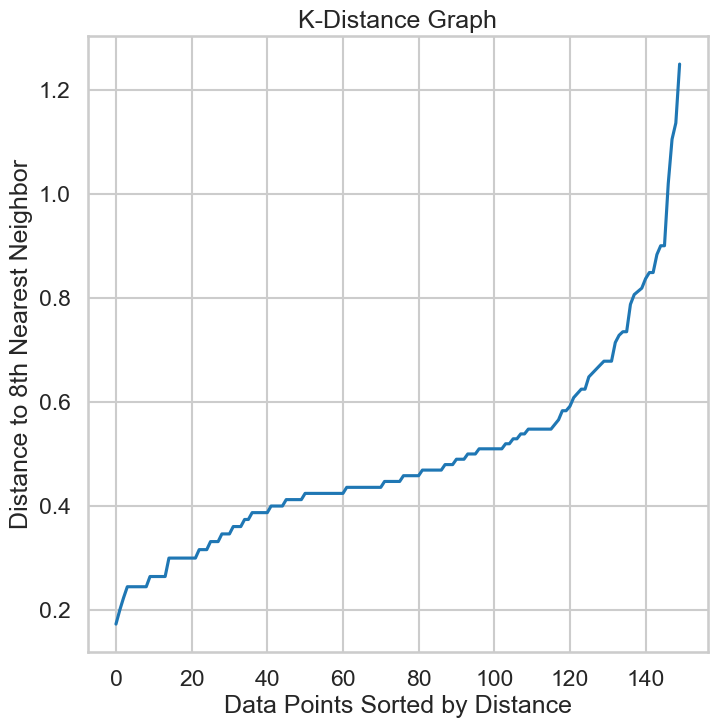

In [213]:
k = 8  # MIn samples = 8 since we have 4 features
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(iris_df)
distances, _ = neigh.kneighbors(iris_df)

# Sort distances for the k-th nearest neighbor
sorted_distances = np.sort(distances[:, -1])
plt.plot(sorted_distances)
plt.ylabel("Distance to {}th Nearest Neighbor".format(k))
plt.xlabel("Data Points Sorted by Distance")
plt.title("K-Distance Graph")
plt.show()

In [284]:
# Define ranges for eps and min_samples
eps_values = np.arange(0.1, 2, 0.05)  # Adjust based on the K-distance plot
min_samples_values = range(8, 25, 1)  # statrting with the recommended min_samples (min_samples= 2 * no.features )

best_score = -1
best_params = {}

# Grid search over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(iris_df)
        unique_clusters = set(labels) - {-1}  # Exclude noise points
        if len(unique_clusters) > 1:  # Ensure at least 2 clusters exist
            score = silhouette_score(iris_df, labels)
            if score > best_score:
                best_score = score
                best_params = {"eps": eps, "min_samples": min_samples}
                numclusters = len(unique_clusters)


print(
    f"Best Parameters: eps={best_params['eps']:.3f}, min_samples={best_params['min_samples']}"
)
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"num_clusters: {numclusters}")

Best Parameters: eps=0.900, min_samples=8
Best Silhouette Score: 0.6867
num_clusters: 2


In [285]:
# Define ranges for eps and min_samples
eps_values = np.arange(0.1, 2, 0.05)  # Adjust based on the K-distance plot
min_samples_values = range(8, 25, 1)  # statrting with the recommended min_samples (min_samples= 2 * no.features )

best_score = 88899
best_params = {}

# Grid search over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(iris_df)
        unique_clusters = set(labels) - {-1}  # Exclude noise points
        if len(unique_clusters) > 1:  # Ensure at least 2 clusters exist
            score = davies_bouldin_score(iris_df, labels)
            if score < best_score:
                best_score = score
                best_params = {"eps": eps, "min_samples": min_samples}
                numclusters = len(unique_clusters)


print(
    f"Best Parameters: eps={best_params['eps']:.3f}, min_samples={best_params['min_samples']}"
)
print(f"Davies-Bouldin Score: {best_score:.4f}")
print(f"num_clusters: {numclusters}")

Best Parameters: eps=0.900, min_samples=8
Davies-Bouldin Score: 0.3828
num_clusters: 2


#### Optimal

In [258]:
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
labels = dbscan.fit_predict(iris_df)
print(f"Best Silhouette Score: {silhouette_score(iris_df, labels):.4f}")
print(f"Davies-Bouldin Score = {davies_bouldin_score(iris_df,labels):.4f}")
print(f"num_clusters: {numclusters}")

Best Silhouette Score: 0.6867
Davies-Bouldin Score = 0.3828
num_clusters: 2


Since both metric gave the same parameters the optimal model is with num_clusters = 2 achieving 0.68 siluette score.
however its already known that data should be clustered into 3 clusters

## Customer dataset
Repeat all the above on the customer data set 

In [312]:
df = pd.read_csv(r"E:\GUC\Sem 10\(NETW 1013) Machine Learning\Week 3\3 - Clustering Project (Project)\Customer data.csv")
df

ID  Sex  Marital status  Age  Education  Income  Occupation  \
0     100000001    0               0   67          2  124670           1   
1     100000002    1               1   22          1  150773           1   
2     100000003    0               0   49          1   89210           0   
3     100000004    0               0   45          1  171565           1   
4     100000005    0               0   53          1  149031           1   
...         ...  ...             ...  ...        ...     ...         ...   
1995  100001996    1               0   47          1  123525           0   
1996  100001997    1               1   27          1  117744           1   
1997  100001998    0               0   31          0   86400           0   
1998  100001999    1               1   24          1   97968           0   
1999  100002000    0               0   25          0   68416           0   

      Settlement size  
0                   2  
1                   2  
2                   0  
3                   1  
4                   1  
...               ...  
1995                0  
1996                0  
1997                0  
1998                0  
1999                0  

[2000 rows x 8 columns]

- Its clear from the data that it should be scaled due to the clear diff in magnetudes between income, age and other columns.
- Another thing to note is that we dont need ID column since it doesnot provide any information it only induces high cardinality so it can not be encodee.

### Explloration & preprocessing

In [316]:
df=df.drop(['ID'],axis=1)

In [318]:
df.head()

Sex  Marital status  Age  Education  Income  Occupation  Settlement size
0    0               0   67          2  124670           1                2
1    1               1   22          1  150773           1                2
2    0               0   49          1   89210           0                0
3    0               0   45          1  171565           1                1
4    0               0   53          1  149031           1                1

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int64
 1   Marital status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement size  2000 non-null   int64
dtypes: int64(7)
memory usage: 109.5 KB


In [322]:
df.isna().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

In [324]:
numerical_features = ['Age','Income']
categorical_features = df.drop(numerical_features,axis=1).columns
categorical_features

Index(['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size'], dtype='object')

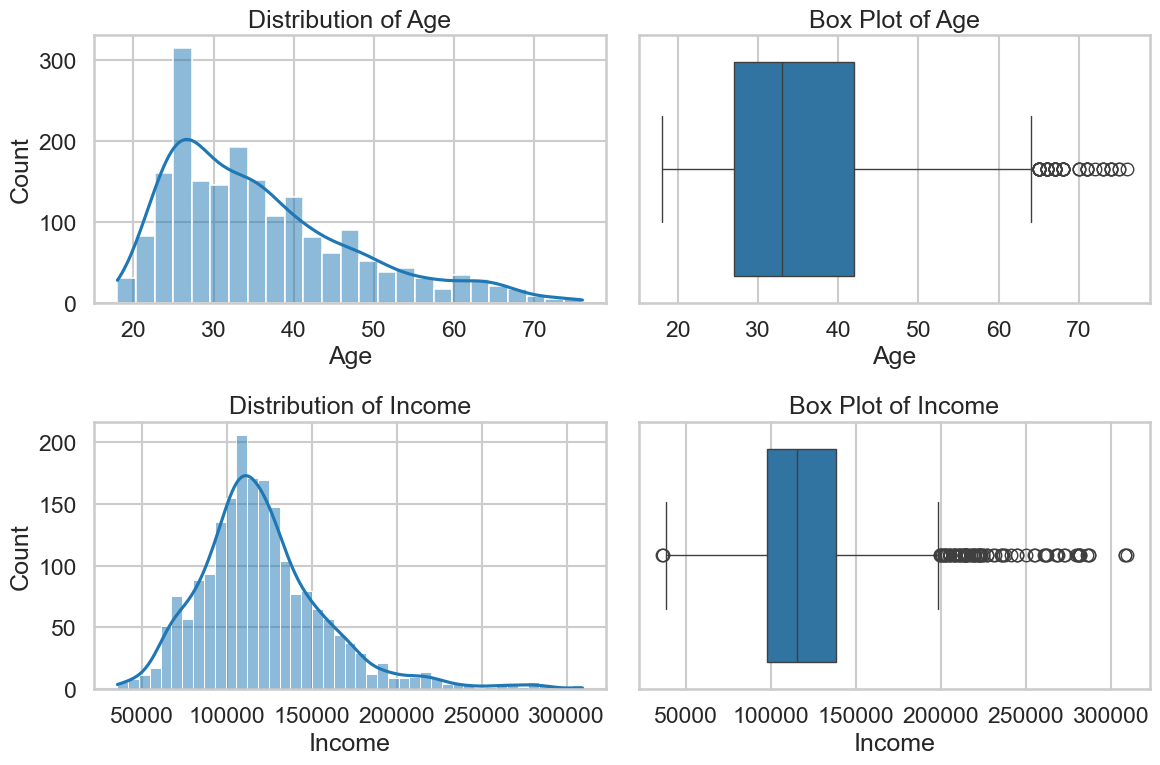

In [326]:
# Set up the figure and subplots
numeric_df = df[numerical_features]
num_columns = len(numeric_df.columns)  # Number of columns in your DataFrame
fig, axes = plt.subplots(num_columns, 2, figsize=(12, num_columns * 4))  # 2 subplots (distribution and boxplot) for each column

# Loop through each column to create distribution and boxplot
for i, column in enumerate(numeric_df.columns):
    # Distribution Plot
    sns.histplot(numeric_df[column], ax=axes[i, 0], kde=True)  # kde=True adds a kernel density estimate (smoothed curve)
    axes[i, 0].set_title(f'Distribution of {column}')

    # Box Plot
    sns.boxplot(x=numeric_df[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {column}')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

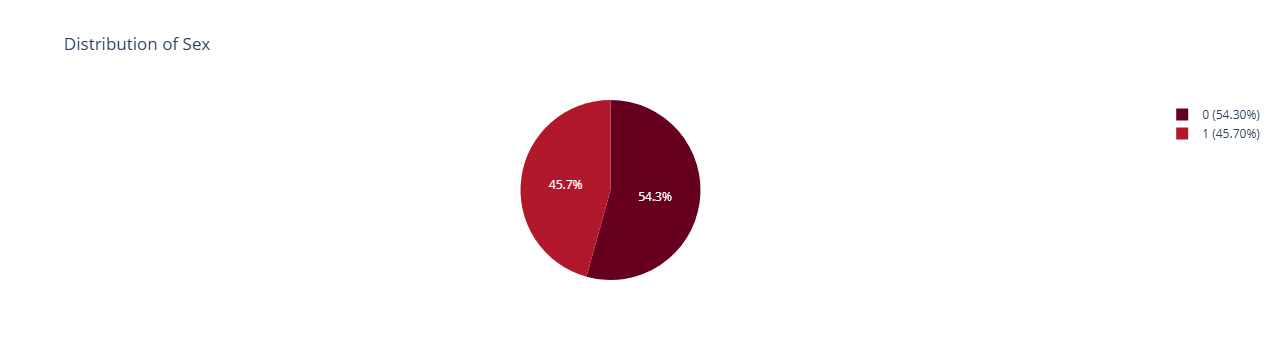

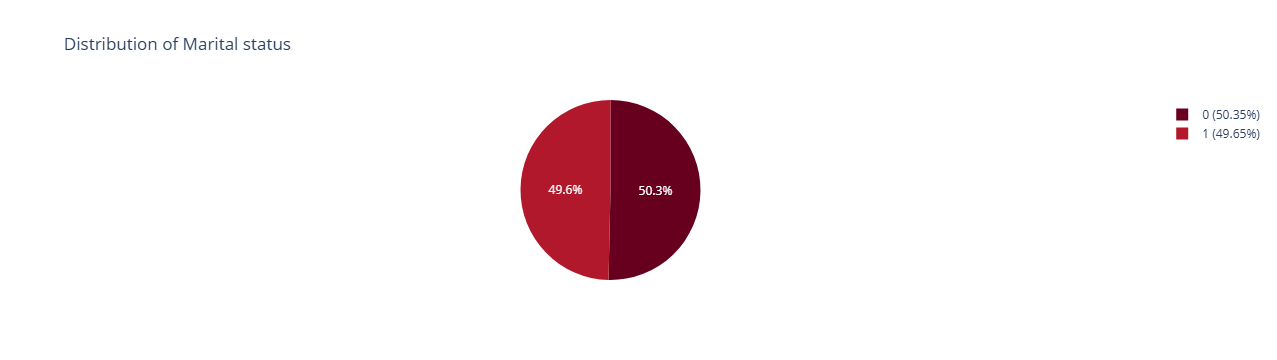

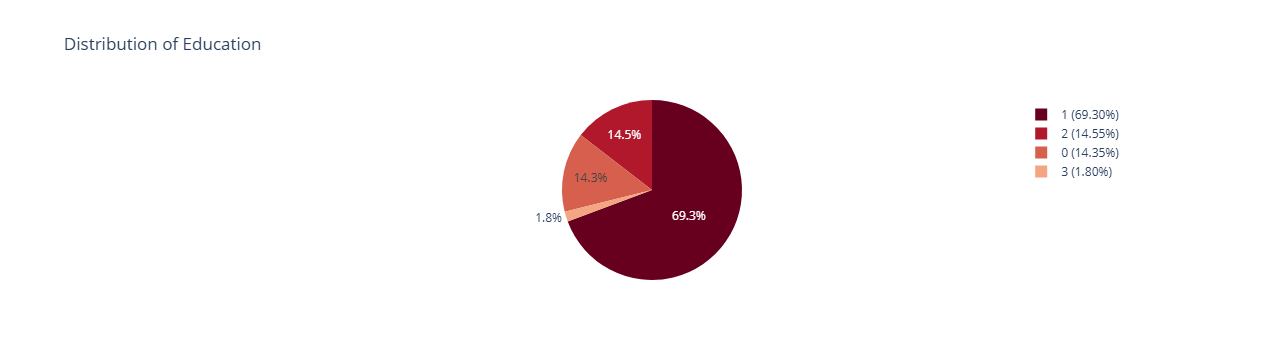

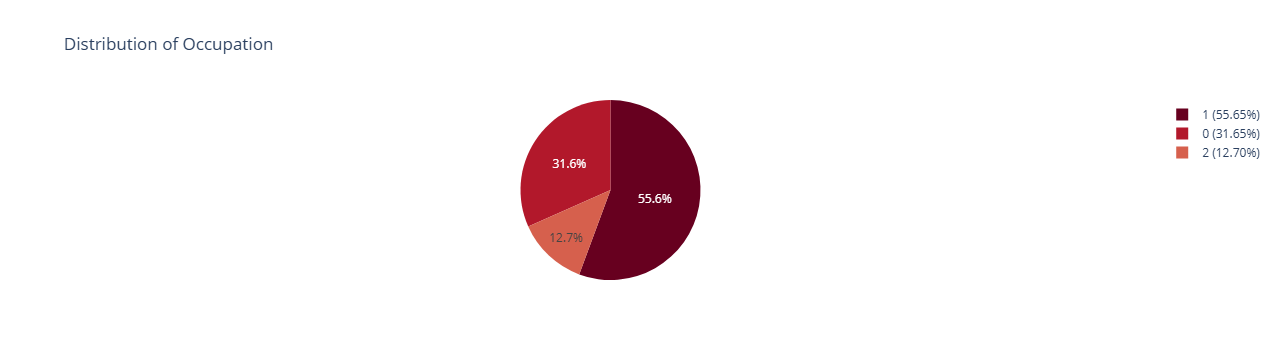

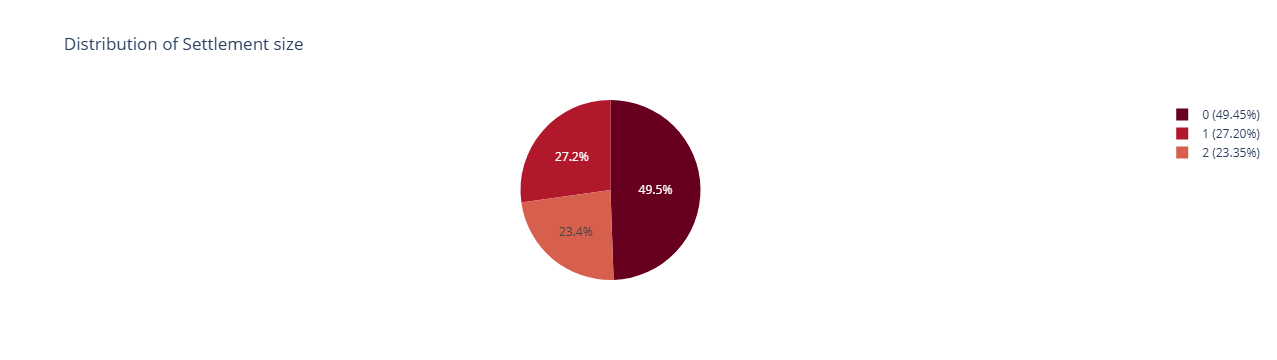

In [332]:
# Loop through categorical features
for feature in categorical_features:
    type_counts = df[feature].value_counts()
    percentages = type_counts / type_counts.sum() * 100

    # Create labels with percentages
    labels = [f'{label} ({percent:.2f}%)' for label, percent in zip(type_counts.index, percentages)]

    # Create a pie chart
    fig = px.pie(values=type_counts.values, names=labels, 
                 title=f'Distribution of {feature}', 
                 color_discrete_sequence=px.colors.sequential.RdBu, 
                 hole=0)  

    # Show the plot
    fig.show()

### Scaling

In [333]:
df_scaled=df.copy()
df_scaled[df.columns] = StandardScaler().fit_transform(df)
df_scaled

Sex  Marital status       Age  Education    Income  Occupation  \
0    -0.917399       -0.993024  2.653614   1.604323  0.097524    0.296823   
1     1.090038        1.007025 -1.187132  -0.063372  0.782654    0.296823   
2    -0.917399       -0.993024  1.117316  -0.063372 -0.833202   -1.269525   
3    -0.917399       -0.993024  0.775916  -0.063372  1.328386    0.296823   
4    -0.917399       -0.993024  1.458716  -0.063372  0.736932    0.296823   
...        ...             ...       ...        ...       ...         ...   
1995  1.090038       -0.993024  0.946616  -0.063372  0.067471   -1.269525   
1996  1.090038        1.007025 -0.760382  -0.063372 -0.084265    0.296823   
1997 -0.917399       -0.993024 -0.418983  -1.731068 -0.906957   -1.269525   
1998  1.090038        1.007025 -1.016432  -0.063372 -0.603329   -1.269525   
1999 -0.917399       -0.993024 -0.931082  -1.731068 -1.378987   -1.269525   

      Settlement size  
0            1.552326  
1            1.552326  
2           -0.909730  
3            0.321298  
4            0.321298  
...               ...  
1995        -0.909730  
1996        -0.909730  
1997        -0.909730  
1998        -0.909730  
1999        -0.909730  

[2000 rows x 7 columns]

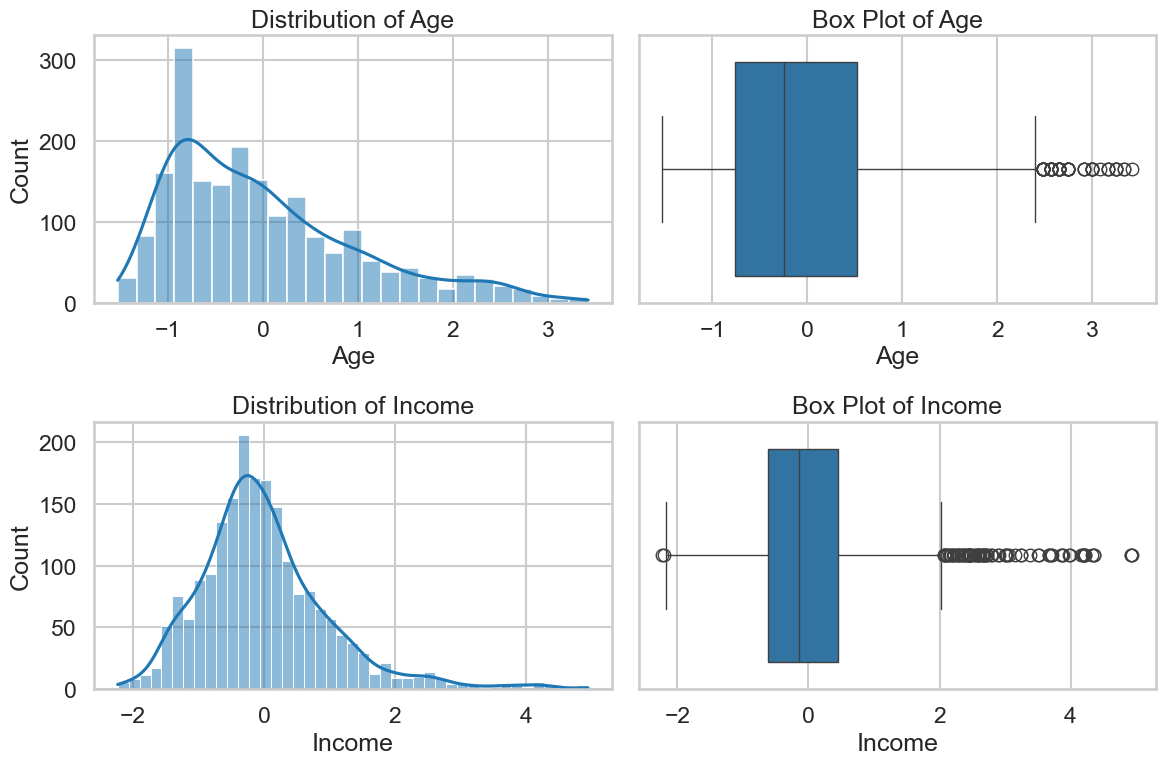

In [338]:
# Set up the figure and subplots
numeric_df = df_scaled[numerical_features]
num_columns = len(numeric_df.columns)  # Number of columns in your DataFrame
fig, axes = plt.subplots(num_columns, 2, figsize=(12, num_columns * 4))  # 2 subplots (distribution and boxplot) for each column

# Loop through each column to create distribution and boxplot
for i, column in enumerate(numeric_df.columns):
    # Distribution Plot
    sns.histplot(numeric_df[column], ax=axes[i, 0], kde=True)  # kde=True adds a kernel density estimate (smoothed curve)
    axes[i, 0].set_title(f'Distribution of {column}')

    # Box Plot
    sns.boxplot(x=numeric_df[column], ax=axes[i, 1])
    axes[i, 1].set_title(f'Box Plot of {column}')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

### Clustering

#### Kmeans

##### Tunning

In [162]:
best_k = None
ssd = []
sil_score = []
best_score = -1
for k in range(2, 10):  # Min 2 clusters for silhouette score
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    labels = kmeans.fit_predict(iris_df)
    score = silhouette_score(iris_df, labels)
    ssd.append(kmeans.inertia_)
    sil_score.append(score)
    print(f'K={k}, Silhouette Score: {score:.3f}')
    
    if score > best_score:
        best_score = score
        best_k = k

print(f'Optimal Number of Clusters (based on Silhouette score): {best_k}')

K=2, Silhouette Score: 0.681
K=3, Silhouette Score: 0.551
K=4, Silhouette Score: 0.498
K=5, Silhouette Score: 0.493
K=6, Silhouette Score: 0.368
K=7, Silhouette Score: 0.354
K=8, Silhouette Score: 0.345
K=9, Silhouette Score: 0.316
Optimal Number of Clusters (based on Silhouette score): 2


Text(0, 0.5, 'silhouette_score')

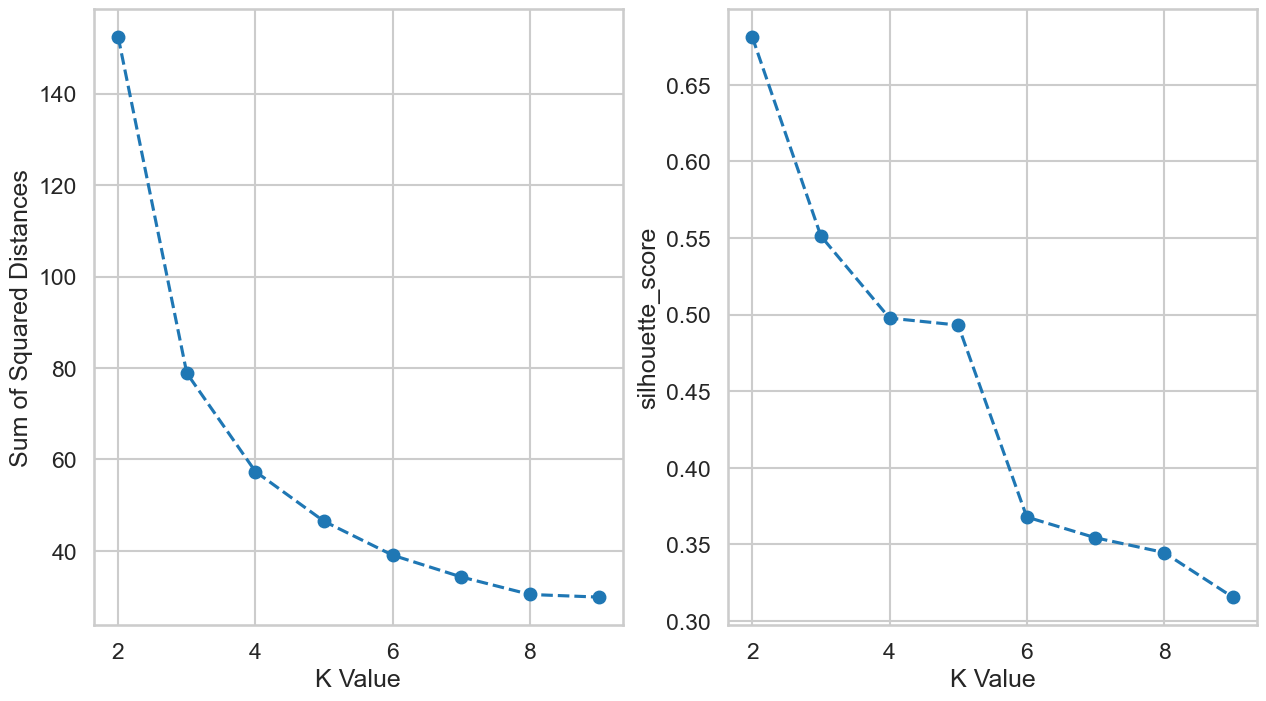

In [154]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.plot(range(2, 10, 1), ssd, "o--")
ax1.set_xlabel("K Value")
ax1.set_ylabel("Sum of Squared Distances")
ax2.plot(range(2, 10, 1), sil_score, "o--")
ax2.set_xlabel("K Value")
ax2.set_ylabel("silhouette_score")

- The curve (left graph) drops sharply from K=2 to K=3 and then flattens more gradually from K=3 to K=4, 5, etc.
- This drop is clearly seen in the next graph (diff plot) where at x=2 (corressponds to k=3) the diff between it and x=1 is much greater than that between itself and x=3
- Silhouette Score plot (right graph) also suggests K=3, as the score drops significantly after K=3.

[152.3479517603579, 78.8556658259773, 57.35088021295475, 46.472230158730156, 39.066035353535355, 34.3058152958153, 30.476222943722952, 29.90624665913797]


Text(0.5, 1.0, 'diff plot')

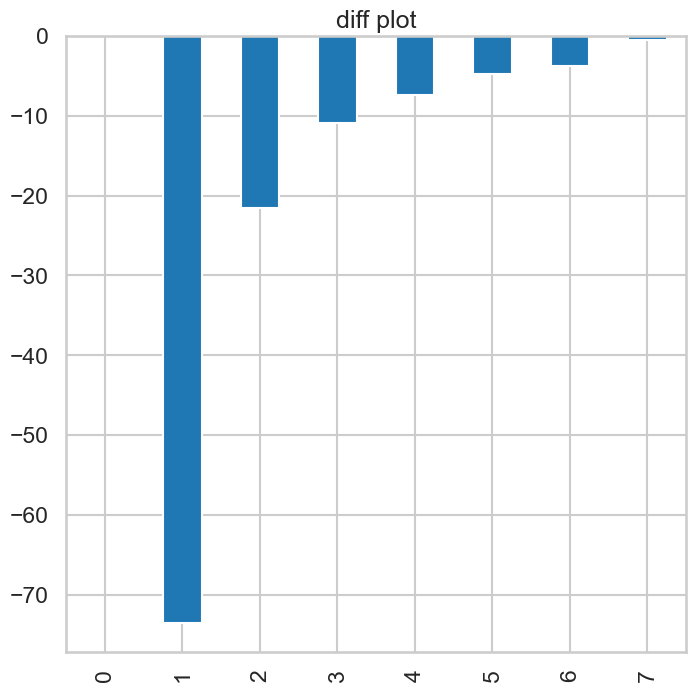

In [156]:
print(ssd)
pd.Series(ssd).diff().plot(kind="bar")
plt.title("diff plot")

#### Hierarchal Clustering

#### DBScan